# Lyric Mood Classification - Mood Classification

In the [word_embeddings](word_embeddings.ipynb) notebook, we demonstrated our embeddings model based on word2vec. In this notebook, we use those embeddings to produce real classification results with a neural network.

First, we split our labeled data into the classic train-dev-test split.

Second, we establish a baseline classification with simple classifiers.

Third, we demonstrate our neural network architecture and model for mood classification.

In [1]:
# Project Imports
from index_lyrics import read_file_contents
from label_lyrics import CSV_LABELED_LYRICS
from scrape_lyrics import LYRICS_TXT_DIR
from lyrics2vec import lyrics2vec

# Python and Package Imports
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import lyrics2vec
import datetime
import json
import time
import csv
import os

%matplotlib inline

## Dataset

The dataset consists of a large number of text files where each file represents a different song. The songs are indexed by a csv file produced by `label_lyrics.py`. We can use the index to retrieve a song's lyrics and observe its matched mood.

We drop all songs that are not english, do not have lyrics available, and do not have a matched mood as classifying across languages is out of scope of this project and no classification can be done on a song without lyrics or without a matched mood.

In [2]:
# we leave out the musixmatch id, artist, and title cols
df = pd.read_csv('data/labeled_lyrics_expanded.csv', usecols=['msd_id', 'msd_artist', 'msd_title', 'is_english', 'lyrics_available', 'wordcount', 'lyrics_filename', 'mood', 'found_tags', 'matched_mood'])
df.columns

/home/jcworkma/jack/w266-group-project_lyric-mood-classification/.venv_w266_project/lib/python3.5/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Index(['msd_id', 'msd_artist', 'msd_title', 'is_english', 'lyrics_available',
       'wordcount', 'lyrics_filename', 'mood', 'found_tags', 'matched_mood'],
      dtype='object')

In [3]:
print('Df shape:', df.shape)
df.describe()

Df shape: (779056, 10)


,is_english,lyrics_available,wordcount,found_tags,matched_mood
count,779056.000000,779056.000000,779056.000000,779056.000000,779056.000000
mean,0.342566,0.420039,87.716389,5.870052,-0.575658
std,0.474571,0.493565,141.151970,19.502538,0.638805
min,-1.000000,0.000000,-1.000000,-1.000000,-1.000000
25%,0.000000,0.000000,0.000000,-1.000000,-1.000000
50%,0.000000,0.000000,0.000000,-1.000000,-1.000000
75%,1.000000,1.000000,161.000000,1.000000,0.000000
max,1.000000,1.000000,8623.000000,100.000000,1.000000


In [4]:
df = df[df.is_english == 1]
print('After is_english filter:', df.shape)
df = df[df.lyrics_available == 1]
print('After lyrics_available filter:', df.shape)
df = df[df.matched_mood == 1]
print('After matched_mood filter:', df.shape)

After is_english filter: (266879, 10)
After lyrics_available filter: (266783, 10)
After matched_mood filter: (63803, 10)


In [5]:
# remove no longer needed columns to conserve memory
df = df.drop(['is_english', 'lyrics_available', 'matched_mood'], axis=1)

In [6]:
# create a categorical data column for moods
# thank you: https://stackoverflow.com/questions/38088652/pandas-convert-categories-to-numbers
df.mood = pd.Categorical(df.mood)
df['mood_cats'] = df.mood.cat.codes
print(df['mood_cats'].unique())
print(df.shape)

[ 4  7 15  2  1  5 17 16 11  0 13 12  9  3  8  6 10 14]
(63803, 8)


In [7]:
# read in the lyrics of each song
def extract_lyrics(lyrics_filepath):
    lyrics = ''
    if os.path.exists(lyrics_filepath):
        lyrics = read_file_contents(lyrics_filepath)[0]
    return lyrics

def make_lyrics_txt_path(lyrics_filename):
    return os.path.join(LYRICS_TXT_DIR, lyrics_filename) + '.txt'

# here we make use of panda's apply function to parallelize the IO operation
df['lyrics'] = df.lyrics_filename.apply(lambda x: extract_lyrics(make_lyrics_txt_path(x)))
df.lyrics.head()

3     And Oceans\nMiscellaneous\nNew Model World\n[i...
7     Electro eroticism\nIntelligence is sexy\nElect...
17    You fight just for the sake of it\nYou know wh...
19    I'm in the dark, I'd like to read his mind\nBu...
25    There was a time\nYou opened up every doorway\...
Name: lyrics, dtype: object

The final number of songs with a matched mood: 63803


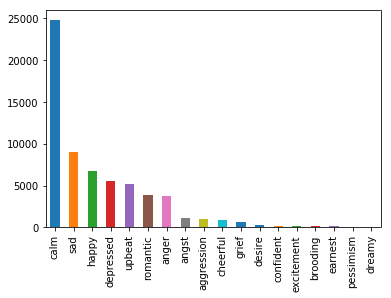

In [8]:
print('The final number of songs with a matched mood:', df.shape[0])
_ = df.mood.value_counts().plot(kind='bar')

In [10]:
df.mood.value_counts()

calm          24733
sad            8986
happy          6689
depressed      5584
upbeat         5193
romantic       3849
anger          3809
angst          1085
aggression     1015
cheerful        946
grief           691
desire          267
confident       224
excitement      218
brooding        212
earnest         148
pessimism        85
dreamy           69
Name: mood, dtype: int64

## Train, Dev, & Test

With our dataset index in hand, we are prepared to split the data.

In [11]:
# thank you: https://stackoverflow.com/questions/38250710/how-to-split-data-into-3-sets-train-validation-and-test/38251213#38251213
# optional random dataframe shuffle
#df = df.reindex(np.random.permutation(df.index))
np.random.seed(12)
def split_data(data):
    return np.split(data.sample(frac=1), [int(.6*len(data)), int(.8*len(data))])

df_train, df_dev, df_test = split_data(df)

In [12]:
print('Train:', df_train.shape)
print('Dev:', df_dev.shape)
print('Test:', df_test.shape)

Train: (38281, 9)
Dev: (12761, 9)
Test: (12761, 9)


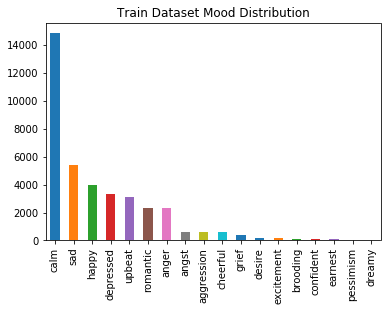

In [13]:
# thank you: https://stackoverflow.com/questions/14992644/turn-pandas-dataframe-of-strings-into-histogram
_ = df_train.mood.value_counts().plot(kind='bar', title='Train Dataset Mood Distribution')

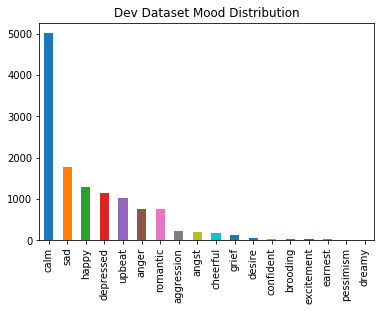

In [14]:
_ = df_dev.mood.value_counts().plot(kind='bar', title='Dev Dataset Mood Distribution')

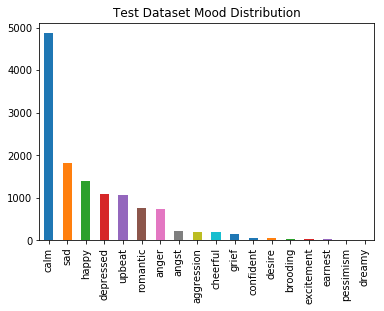

In [15]:
_ = df_test.mood.value_counts().plot(kind='bar', title='Test Dataset Mood Distribution')

## Baselines

### Most-Common-Case Classification

In [16]:
def pprint_accuracy(acc):
    return '{0:.02f}%'.format(acc * 100)

def most_common_case_classification(x, y):
    assert len(x) == len(y)
    total_count = len(x)
    common_count = y.value_counts().max()
    accuracy = common_count / total_count
    return accuracy

In [17]:
print('The most common case for each dataset split is')
print('\tTrain:', df_train.mood.value_counts().idxmax())
print('\tDev:', df_dev.mood.value_counts().idxmax())
print('\tTest:', df_test.mood.value_counts().idxmax())
#df_test.loc[df_test.mood_classes.idxmax()].mood
print('The accuracy of the most-common-case classifier for each dataset split is')
print('\tTrain:', pprint_accuracy(most_common_case_classification(df_train.lyrics_filename, df_train.mood)))
print('\tDev:', pprint_accuracy(most_common_case_classification(df_dev.lyrics_filename, df_dev.mood)))
print('\tTest:', pprint_accuracy(most_common_case_classification(df_test.lyrics_filename, df_test.mood)))


The most common case for each dataset split is
	Train: calm
	Dev: calm
	Test: calm
The accuracy of the most-common-case classifier for each dataset split is
	Train: 38.81%
	Dev: 39.26%
	Test: 38.15%


### Naive-Bayes Classification

The Naive-Bayes Classifier will require the actual lyrical text for classification, so we begin by reading into memory the text for each song in our dataset.

Once we have the lyrics, we use the python sklearn package to vectorize and process the lyrical text, fit the Naive Bayes Classifier, and compute the accuracy.

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

def prep_lyrics_for_nb(lyrics_series, count_vect=None, tfidf_transformer=None):
   # thank you: https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html
    if not count_vect:
        count_vect = CountVectorizer()
        count_vect = count_vect.fit(lyrics_series)
    x_train_counts = count_vect.transform(lyrics_series)
    if not tfidf_transformer:
        tfidf_transformer = TfidfTransformer()
        tfidf_transformer = tfidf_transformer.fit(x_train_counts)
    x_train_tfidf = tfidf_transformer.fit_transform(x_train_counts)
    return count_vect, x_train_counts, tfidf_transformer, x_train_tfidf

# convert lyrics to counts and term-frequencies
count_vect, x_train_counts, tfidf_transformer, x_train_tfidf = prep_lyrics_for_nb(df_train.lyrics)
print(x_train_tfidf.shape)
_, x_dev_counts, _, x_dev_tfidf = prep_lyrics_for_nb(df_dev.lyrics, count_vect, tfidf_transformer)
print(x_dev_tfidf.shape)
_, x_test_counts, _, x_test_tfidf = prep_lyrics_for_nb(df_test.lyrics, count_vect, tfidf_transformer)
print(x_test_tfidf.shape)

(38281, 62247)
(12761, 62247)
(12761, 62247)


In [19]:
clf = MultinomialNB().fit(x_train_tfidf, df_train.mood_cats) 
dev_acc = clf.score(x_dev_tfidf, df_dev.mood_cats)
print('Naive Bayes Classifier Dev Accuracy:', pprint_accuracy(dev_acc))
test_acc = clf.score(x_test_tfidf, df_test.mood_cats)
print('Naive Bayes Classifier Test Accuracy:', pprint_accuracy(test_acc))

Naive Bayes Classifier Dev Accuracy: 39.43%
Naive Bayes Classifier Test Accuracy: 38.25%


### SVM Classification

From [Corona & O'Mahony](https://www.researchgate.net/publication/280733696_An_Exploration_of_Mood_Classification_in_the_Million_Songs_Dataset), SVMs have been used with success in this area. Here we see that they do provide a sizeable increase in accuracy over NB.

In [20]:
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42,
            max_iter=5, tol=None).fit(x_train_tfidf, df_train.mood_cats)
dev_acc = clf.score(x_dev_tfidf, df_dev.mood_cats)
print('SVM Classifier Dev Accuracy:', pprint_accuracy(dev_acc))
test_acc = clf.score(x_test_tfidf, df_test.mood_cats)
print('SVM Classifier Test Accuracy:', pprint_accuracy(test_acc))

SVM Classifier Dev Accuracy: 43.76%
SVM Classifier Test Accuracy: 42.89%


## Neural Networks

### CNN

http://www.wildml.com/2015/12/implementing-a-cnn-for-text-classification-in-tensorflow/

CNNs process textual input different than a Naive Bayes or SVM classifier. We perform the following data processing steps on all lyrics:
* Truncate/extend all songs to the 75% wordcount percentile
* Tokenize lyrics with nltk's word_tokenize function
* Remove all stopwords that match from within nltk's stopwords corpus
* Remove punctuation

In [21]:
pctiles = df.wordcount.describe()
print(pctiles)
cutoff = int(pctiles[pctiles.index.str.startswith('75%')][0])
print('\nAll songs will be limited to {0} words'.format(cutoff))

count    63803.000000
mean       231.658982
std        139.035896
min          1.000000
25%        143.000000
50%        204.000000
75%        282.000000
max       2913.000000
Name: wordcount, dtype: float64

All songs will be limited to 282 words


In [24]:
from importlib import reload
reload(lyrics2vec)
lyrics_vectorizer = lyrics2vec.lyrics2vec.InitFromLyrics()

In [25]:
def normalize_lyrics(lyrics, max_length, lyrics_vectorizer):
    """
    Tokenize, process, shorten/lengthen, and vectorize lyrics
    """
    lyrics = lyrics2vec.lyrics_preprocessing(lyrics)
    if len(lyrics) > max_length:
        lyrics = lyrics[:max_length]
    else:
        lyrics += ['<PAD>'] * (int(max_length) - int(len(lyrics)))

    lyric_vector = lyrics_vectorizer.transform(lyrics)
    return lyric_vector

start = time.time()

# here we make use of panda's apply function to parallelize the IO operation (again)
df_train['normalized_lyrics'] = df_train.lyrics.apply(lambda x: normalize_lyrics(x, cutoff, lyrics_vectorizer))
print('train data normalized ({0} minutes)'.format((time.time() - start) / 60))
print(df_train.normalized_lyrics.head())

df_dev['normalized_lyrics'] = df_dev.lyrics.apply(lambda x: normalize_lyrics(x, cutoff, lyrics_vectorizer))
print('dev data normalized ({0} minutes)'.format((time.time() - start) / 60))
print(df_dev.normalized_lyrics.head())

df_test['normalized_lyrics'] = df_test.lyrics.apply(lambda x: normalize_lyrics(x, cutoff, lyrics_vectorizer))
print('test data normalized ({0} minutes)'.format((time.time() - start) / 60))
print(df_test.normalized_lyrics.head())

print('\nExample of padding:')
example = df_train.normalized_lyrics[df_train.normalized_lyrics.str.len() == cutoff].iloc[0]
print('\tFirst 5 tokens: {0}'.format(example[:5]))
print('\tLast 5 tokens: {0}.'.format(example[-5:]))

print('\nElapsed Time: {0} minutes'.format((time.time() - start) / 60))

train data normalized (0.8400406042734782 minutes)
228247    [526, 43, 99, 5, 15, 77, 234, 179, 19, 86, 383...
214654    [37, 93, 868, 3364, 2, 12, 596, 1668, 873, 4, ...
175139    [71, 44, 297, 250, 2271, 1511, 127, 1310, 231,...
58579     [37, 93, 1, 100, 382, 122, 181, 38, 162, 35, 1...
196716    [253, 7, 43, 22, 1, 209, 209, 3, 147, 7, 94, 7...
Name: normalized_lyrics, dtype: object
dev data normalized (1.1153544306755065 minutes)
149604    [315, 26, 8, 95, 280, 7, 136, 201, 5, 37330, 4...
71942     [37, 93, 24, 68, 1462, 12, 213, 6044, 43, 231,...
91524     [37, 93, 269, 14574, 130, 1032, 1107, 6, 1467,...
238415    [37, 93, 60, 245, 800, 2179, 0, 288, 250, 0, 1...
162087    [37, 143, 1495, 143, 146, 48086, 14761, 391, 4...
Name: normalized_lyrics, dtype: object
test data normalized (1.3944415728251138 minutes)
248608    [24, 26, 12, 766, 7, 222, 6, 45, 2295, 1402, 2...
240285    [99, 212, 99, 99, 315, 124, 1840, 194, 235, 33...
200631    [15, 294, 3904, 656, 193, 1133, 193, 4136,

# **Following code is borrowed from [this excellent and very helpful blog post](http://www.wildml.com/2015/12/implementing-a-cnn-for-text-classification-in-tensorflow/) to PoC the validity of the preprocessed tokens and word embeddings**

And here's a walkthrough of that blog post's code: https://agarnitin86.github.io/blog/2016/12/23/text-classification-cnn

In [26]:
class TextCNN(object):
    """
    A CNN for text classification.
    Uses an embedding layer, followed by a convolutional, max-pooling and softmax layer.
    """
    def __init__(
      self, sequence_length, num_classes, vocab_size,
      embedding_size, filter_sizes, num_filters, l2_reg_lambda=0.0,
      embeddings=None):

        # Placeholders for input, output and dropout
        self.input_x = tf.placeholder(tf.int32, [None, sequence_length], name="input_x")
        self.input_y = tf.placeholder(tf.float32, [None, num_classes], name="input_y")
        self.dropout_keep_prob = tf.placeholder(tf.float32, name="dropout_keep_prob")

        # Keeping track of l2 regularization loss (optional)
        l2_loss = tf.constant(0.0)

        # Embedding layer
        # for loading word2vec: https://stackoverflow.com/questions/35687678/using-a-pre-trained-word-embedding-word2vec-or-glove-in-tensorflow
        with tf.device('/cpu:0'), tf.name_scope("embedding"):

            self.pretrained_embeddings = embeddings is not None
            if self.pretrained_embeddings:
                self.W = tf.get_variable(
                    shape=embeddings.shape,
                    initializer=tf.constant_initializer(embeddings),
                    trainable=True,
                    name="W")
            else:
                self.W = tf.Variable(
                    tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0),
                    name="W")
            
            self.embedded_chars = tf.nn.embedding_lookup(self.W, self.input_x)
            self.embedded_chars_expanded = tf.expand_dims(self.embedded_chars, -1)

        # Create a convolution + maxpool layer for each filter size
        pooled_outputs = []
        for i, filter_size in enumerate(filter_sizes):
            with tf.name_scope("conv-maxpool-%s" % filter_size):
                # Convolution Layer
                filter_shape = [filter_size, embedding_size, 1, num_filters]
                Wconv = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.1), name="Wconv")
                b = tf.Variable(tf.constant(0.1, shape=[num_filters]), name="b")
                conv = tf.nn.conv2d(
                    self.embedded_chars_expanded,
                    Wconv,
                    strides=[1, 1, 1, 1],
                    padding="VALID",
                    name="conv")
                # Apply nonlinearity
                h = tf.nn.relu(tf.nn.bias_add(conv, b), name="relu")
                # Maxpooling over the outputs
                pooled = tf.nn.max_pool(
                    h,
                    ksize=[1, sequence_length - filter_size + 1, 1, 1],
                    strides=[1, 1, 1, 1],
                    padding='VALID',
                    name="pool")
                pooled_outputs.append(pooled)

        # Combine all the pooled features
        num_filters_total = num_filters * len(filter_sizes)
        self.h_pool = tf.concat(pooled_outputs, 3)
        self.h_pool_flat = tf.reshape(self.h_pool, [-1, num_filters_total])

        # Add dropout
        with tf.name_scope("dropout"):
            self.h_drop = tf.nn.dropout(self.h_pool_flat, self.dropout_keep_prob)

        # Final (unnormalized) scores and predictions
        with tf.name_scope("output"):
            Wconv = tf.get_variable(
                "Wconv",
                shape=[num_filters_total, num_classes],
                initializer=tf.contrib.layers.xavier_initializer())
            b = tf.Variable(tf.constant(0.1, shape=[num_classes]), name="b")
            l2_loss += tf.nn.l2_loss(Wconv)
            l2_loss += tf.nn.l2_loss(b)
            self.scores = tf.nn.xw_plus_b(self.h_drop, Wconv, b, name="scores")
            self.predictions = tf.argmax(self.scores, 1, name="predictions")

        # Calculate mean cross-entropy loss
        with tf.name_scope("loss"):
            losses = tf.nn.softmax_cross_entropy_with_logits(logits=self.scores, labels=self.input_y)
            self.loss = tf.reduce_mean(losses) + l2_reg_lambda * l2_loss

        # Accuracy
        with tf.name_scope("accuracy"):
            correct_predictions = tf.equal(self.predictions, tf.argmax(self.input_y, 1))
            self.accuracy = tf.reduce_mean(tf.cast(correct_predictions, "float"), name="accuracy")

In [37]:
# Parameters
# ==================================================

SAVE_STEP_DATA = True
USE_TIME_AS_KEY = False

# Model Hyperparameters
embedding_dim = 300
filter_sizes = [3,4,5]
num_filters = 64
dropout_keep_prob = 0.5
l2_reg_lambda = 0.01

# Training parameters
batch_size = 64
num_epochs = 10
evaluate_every = 100
checkpoint_every = 100
num_checkpoints = 5

def batch_iter(data, batch_size, num_epochs, shuffle=True):
    """
    Generates a batch iterator for a dataset.
    """
    data = np.array(data)
    data_size = len(data)
    num_batches_per_epoch = int((len(data)-1)/batch_size) + 1
    print('num_batches_per_epoch = {0}'.format(num_batches_per_epoch))
    for epoch in range(num_epochs):
        print('***********************************************')
        print('Epoch {0}/{1}\n'.format(epoch, num_epochs))
        # Shuffle the data at each epoch
        if shuffle:
            shuffle_indices = np.random.permutation(np.arange(data_size))
            shuffled_data = data[shuffle_indices]
        else:
            shuffled_data = data
        for batch_num in range(num_batches_per_epoch):
            print('-----------------------------------------------')
            start_index = batch_num * batch_size
            end_index = min((batch_num + 1) * batch_size, data_size)
            print('Epoch {0}/{1}, Batch {2}/{3} (start={4}, end={5})'.format(
                epoch, num_epochs, batch_num, num_batches_per_epoch, start_index, end_index))
            yield shuffled_data[start_index:end_index]
            
def train(vocab_size, x_train, y_train, x_dev, y_dev, x_test, y_test, train_embeddings=False, embeddings=None):
    # Training
    # ==================================================

    with tf.Graph().as_default():
        session_conf = tf.ConfigProto()
        sess = tf.Session(config=session_conf)
        with sess.as_default():
            cnn = TextCNN(
                sequence_length=x_train.shape[1],
                num_classes=y_train.shape[1],
                #vocab_size=len(vocab_processor.vocabulary_),
                vocab_size=vocab_size,
                embedding_size=embedding_dim,
                filter_sizes=filter_sizes,
                num_filters=num_filters,
                l2_reg_lambda=l2_reg_lambda,
                embeddings=embeddings)

            # Define Training procedure
            global_step = tf.Variable(0, name="global_step", trainable=False)
            optimizer = tf.train.AdamOptimizer(1e-3)
            grads_and_vars = optimizer.compute_gradients(cnn.loss)
            train_op = optimizer.apply_gradients(grads_and_vars, global_step=global_step)

            # Keep track of gradient values and sparsity (optional)
            grad_summaries = []
            for g, v in grads_and_vars:
                if g is not None:
                    grad_hist_summary = tf.summary.histogram("{}/grad/hist".format(v.name), g)
                    sparsity_summary = tf.summary.scalar("{}/grad/sparsity".format(v.name), tf.nn.zero_fraction(g))
                    grad_summaries.append(grad_hist_summary)
                    grad_summaries.append(sparsity_summary)
            grad_summaries_merged = tf.summary.merge(grad_summaries)

            # Output directory for models and summaries
            if USE_TIME_AS_KEY:
                unique_key = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
            else:
                unique_key = 'Em-{0}_FS-{1}_NF-{2}_D-{3}_L2-{4}_B-{5}_Ep-{6}_W2V-{7}{8}_V-{9}'.format(
                    embedding_dim, '-'.join(map(str, filter_sizes)),
                    num_filters,
                    dropout_keep_prob,
                    l2_reg_lambda,
                    batch_size,
                    num_epochs,
                    1 if cnn.pretrained_embeddings else 0,
                    '-Tr' if train_embeddings else '',
                    vocab_size)
            out_dir = os.path.abspath(os.path.join(lyrics2vec.LOGS_TF_DIR, "runs", unique_key))
            os.makedirs(out_dir)
            print("Writing to {}\n".format(out_dir))
            
            # dump params to json in case they need to be referenced later
            with open(os.path.join(out_dir, 'model_params.json'), 'w') as outfile:
                model_params = {
                    'embedding_dim': embedding_dim,
                    'filter_sizes': filter_sizes,
                    'num_filters': num_filters,
                    'dropout_keep_prob': dropout_keep_prob,
                    'l2_reg_lambda': l2_reg_lambda,
                    'batch_size': batch_size,
                    'num_epochs': num_epochs,
                    'evaluate_every': evaluate_every,
                    'checkpoint_every': checkpoint_every,
                    'num_checkpoints': num_checkpoints,
                    'train_embeddings': train_embeddings,
                    'pretrained_embeddings': cnn.pretrained_embeddings
                }
                json.dump(model_params, outfile, sort_keys=True)
                
            # Summaries for loss and accuracy
            loss_summary = tf.summary.scalar("loss", cnn.loss)
            acc_summary = tf.summary.scalar("accuracy", cnn.accuracy)

            # Train Summaries
            summary_dir = os.path.join(out_dir, "summaries")
            train_summary_op = tf.summary.merge([loss_summary, acc_summary, grad_summaries_merged])
            train_summary_writer = tf.summary.FileWriter(os.path.join(summary_dir, "train"), sess.graph)

            # Dev summaries
            dev_summary_op = tf.summary.merge([loss_summary, acc_summary])
            dev_summary_writer = tf.summary.FileWriter(os.path.join(summary_dir, "dev"), sess.graph)

            # Test summaries
            test_summary_op = tf.summary.merge([loss_summary, acc_summary])
            test_summary_writer = tf.summary.FileWriter(os.path.join(summary_dir, "test"), sess.graph)
            
            # Checkpoint directory. Tensorflow assumes this directory already exists so we need to create it
            checkpoint_dir = os.path.abspath(os.path.join(out_dir, "checkpoints"))
            checkpoint_prefix = os.path.join(checkpoint_dir, "model")
            if not os.path.exists(checkpoint_dir):
                os.makedirs(checkpoint_dir)
            saver = tf.train.Saver(tf.global_variables(), max_to_keep=num_checkpoints)

            # Write vocabulary
            #vocab_processor.save(os.path.join(out_dir, "vocab"))

            # Initialize all variables
            sess.run(tf.global_variables_initializer())

            def train_step(x_batch, y_batch, summary_writer=None, step_writer=None):
                """
                A single training step
                """
                feed_dict = {
                  cnn.input_x: x_batch,
                  cnn.input_y: y_batch,
                  cnn.dropout_keep_prob: dropout_keep_prob
                }
                _, step, summaries, loss, accuracy = sess.run(
                    [train_op, global_step, train_summary_op, cnn.loss, cnn.accuracy],
                    feed_dict)
                time_str = datetime.datetime.now().isoformat()
                print("{}: step {}, loss {:g}, acc {:g}".format(time_str, step, loss, accuracy))
                if summary_writer:
                    summary_writer.add_summary(summaries, step)
                if step_writer:
                    step_writer.writerow(['train', time_str, step, loss, accuracy])
                return time_str, step, loss, accuracy

            def dev_step(x_batch, y_batch, summary_writer=None, step_writer=None):
                """
                Evaluates model on a dev set
                """
                feed_dict = {
                  cnn.input_x: x_batch,
                  cnn.input_y: y_batch,
                  cnn.dropout_keep_prob: 1.0
                }
                step, summaries, loss, accuracy = sess.run(
                    [global_step, dev_summary_op, cnn.loss, cnn.accuracy],
                    feed_dict)
                time_str = datetime.datetime.now().isoformat()
                print("{}: step {}, loss {:g}, acc {:g}".format(time_str, step, loss, accuracy))
                if summary_writer:
                    summary_writer.add_summary(summaries, step)
                if step_writer:
                    step_writer.writerow(['train', time_str, step, loss, accuracy])
                return time_str, step, loss, accuracy
                   
            csvwriter = None
            if SAVE_STEP_DATA:
                csvfile = open(os.path.join(out_dir, 'step_data.csv'), 'w')
                csvwriter = csv.writer(csvfile)
                csvwriter.writerow(['dataset', 'time', 'step', 'loss', 'acc'])
                
            # Generate batches
            batches = batch_iter(
                list(zip(x_train, y_train)), batch_size, num_epochs)
            # Training loop. For each batch...
            for batch in batches:
                x_batch, y_batch = zip(*batch)
                train_step(x_batch, y_batch, summary_writer=train_summary_writer, step_writer=csvwriter)
                current_step = tf.train.global_step(sess, global_step)
                if current_step % evaluate_every == 0:
                    print("\nEvaluation:")
                    dev_step(x_dev, y_dev, summary_writer=dev_summary_writer, step_writer=csvwriter)
                    print("")
                if current_step % checkpoint_every == 0:
                    path = saver.save(sess, checkpoint_prefix, global_step=current_step)
                    print("Saved model checkpoint to {}\n".format(path))
                    
            print("\nFinal Test Evaluation:")
            dev_step(x_test, y_test, summary_writer=test_summary_writer, step_writer=csvwriter)


In [34]:
# get our pre-trained word2vec embeddings
lyrics_vectorizer = lyrics2vec.lyrics2vec()
embeddings_loaded = lyrics_vectorizer.load_embeddings()
if embeddings_loaded:
    print('embeddings shape:', lyrics_vectorizer.final_embeddings.shape)
else:
    print('failed to load embeddings!')

embeddings shape: (50000, 300)


In [38]:
V = lyrics2vec.VOCAB_SIZE
#V = 50000
# need to convert lyrics into numpy 2d arrays
# need to convert classes into dummies
train_embeddings = False

train(
    vocab_size=V,
    x_train=np.array(list(df_train.normalized_lyrics)),
    y_train=pd.get_dummies(df_train.mood).values,
    x_dev=np.array(list(df_dev.normalized_lyrics)),
    y_dev=pd.get_dummies(df_dev.mood).values,
    x_test=np.array(list(df_test.normalized_lyrics)),
    y_test=pd.get_dummies(df_test.mood).values,
    train_embeddings=train_embeddings,
    embeddings=lyrics_vectorizer.final_embeddings
)

INFO:tensorflow:Summary name W:0/grad/hist is illegal; using W_0/grad/hist instead.
INFO:tensorflow:Summary name W:0/grad/sparsity is illegal; using W_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-3/Wconv:0/grad/hist is illegal; using conv-maxpool-3/Wconv_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-3/Wconv:0/grad/sparsity is illegal; using conv-maxpool-3/Wconv_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-3/b:0/grad/hist is illegal; using conv-maxpool-3/b_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-3/b:0/grad/sparsity is illegal; using conv-maxpool-3/b_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-4/Wconv:0/grad/hist is illegal; using conv-maxpool-4/Wconv_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-4/Wconv:0/grad/sparsity is illegal; using conv-maxpool-4/Wconv_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-4/b:0/grad/hist is illegal; using conv-max

2018-11-27T04:12:55.932225: step 39, loss 2.22284, acc 0.390625
-----------------------------------------------
Epoch 0/10, Batch 39/599 (start=2496, end=2560)
2018-11-27T04:12:56.277699: step 40, loss 2.39326, acc 0.3125
-----------------------------------------------
Epoch 0/10, Batch 40/599 (start=2560, end=2624)
2018-11-27T04:12:56.591142: step 41, loss 2.36129, acc 0.390625
-----------------------------------------------
Epoch 0/10, Batch 41/599 (start=2624, end=2688)
2018-11-27T04:12:56.902461: step 42, loss 2.15134, acc 0.421875
-----------------------------------------------
Epoch 0/10, Batch 42/599 (start=2688, end=2752)
2018-11-27T04:12:57.237479: step 43, loss 2.42421, acc 0.421875
-----------------------------------------------
Epoch 0/10, Batch 43/599 (start=2752, end=2816)
2018-11-27T04:12:57.557384: step 44, loss 2.29554, acc 0.328125
-----------------------------------------------
Epoch 0/10, Batch 44/599 (start=2816, end=2880)
2018-11-27T04:12:57.867257: step 45, loss 

2018-11-27T04:13:13.095532: step 91, loss 2.09431, acc 0.359375
-----------------------------------------------
Epoch 0/10, Batch 91/599 (start=5824, end=5888)
2018-11-27T04:13:13.427075: step 92, loss 2.32528, acc 0.359375
-----------------------------------------------
Epoch 0/10, Batch 92/599 (start=5888, end=5952)
2018-11-27T04:13:13.760802: step 93, loss 2.35512, acc 0.421875
-----------------------------------------------
Epoch 0/10, Batch 93/599 (start=5952, end=6016)
2018-11-27T04:13:14.100338: step 94, loss 2.11952, acc 0.453125
-----------------------------------------------
Epoch 0/10, Batch 94/599 (start=6016, end=6080)
2018-11-27T04:13:14.446943: step 95, loss 2.20089, acc 0.390625
-----------------------------------------------
Epoch 0/10, Batch 95/599 (start=6080, end=6144)
2018-11-27T04:13:14.781951: step 96, loss 2.03351, acc 0.40625
-----------------------------------------------
Epoch 0/10, Batch 96/599 (start=6144, end=6208)
2018-11-27T04:13:15.111775: step 97, loss

2018-11-27T04:13:36.397551: step 141, loss 2.37847, acc 0.375
-----------------------------------------------
Epoch 0/10, Batch 141/599 (start=9024, end=9088)
2018-11-27T04:13:36.703384: step 142, loss 2.19992, acc 0.375
-----------------------------------------------
Epoch 0/10, Batch 142/599 (start=9088, end=9152)
2018-11-27T04:13:37.043988: step 143, loss 2.14494, acc 0.359375
-----------------------------------------------
Epoch 0/10, Batch 143/599 (start=9152, end=9216)
2018-11-27T04:13:37.387397: step 144, loss 2.22835, acc 0.296875
-----------------------------------------------
Epoch 0/10, Batch 144/599 (start=9216, end=9280)
2018-11-27T04:13:37.730793: step 145, loss 2.18554, acc 0.265625
-----------------------------------------------
Epoch 0/10, Batch 145/599 (start=9280, end=9344)
2018-11-27T04:13:38.079155: step 146, loss 2.00409, acc 0.4375
-----------------------------------------------
Epoch 0/10, Batch 146/599 (start=9344, end=9408)
2018-11-27T04:13:38.397528: step 147

2018-11-27T04:13:53.286058: step 192, loss 2.04412, acc 0.40625
-----------------------------------------------
Epoch 0/10, Batch 192/599 (start=12288, end=12352)
2018-11-27T04:13:53.624516: step 193, loss 2.23438, acc 0.359375
-----------------------------------------------
Epoch 0/10, Batch 193/599 (start=12352, end=12416)
2018-11-27T04:13:53.965535: step 194, loss 1.99257, acc 0.4375
-----------------------------------------------
Epoch 0/10, Batch 194/599 (start=12416, end=12480)
2018-11-27T04:13:54.286985: step 195, loss 2.07998, acc 0.40625
-----------------------------------------------
Epoch 0/10, Batch 195/599 (start=12480, end=12544)
2018-11-27T04:13:54.628354: step 196, loss 2.36547, acc 0.3125
-----------------------------------------------
Epoch 0/10, Batch 196/599 (start=12544, end=12608)
2018-11-27T04:13:54.970780: step 197, loss 2.13416, acc 0.390625
-----------------------------------------------
Epoch 0/10, Batch 197/599 (start=12608, end=12672)
2018-11-27T04:13:55.31

2018-11-27T04:14:16.289249: step 241, loss 2.17375, acc 0.375
-----------------------------------------------
Epoch 0/10, Batch 241/599 (start=15424, end=15488)
2018-11-27T04:14:16.604120: step 242, loss 2.00935, acc 0.359375
-----------------------------------------------
Epoch 0/10, Batch 242/599 (start=15488, end=15552)
2018-11-27T04:14:16.950322: step 243, loss 1.98036, acc 0.5
-----------------------------------------------
Epoch 0/10, Batch 243/599 (start=15552, end=15616)
2018-11-27T04:14:17.282389: step 244, loss 2.12057, acc 0.34375
-----------------------------------------------
Epoch 0/10, Batch 244/599 (start=15616, end=15680)
2018-11-27T04:14:17.604744: step 245, loss 1.97522, acc 0.4375
-----------------------------------------------
Epoch 0/10, Batch 245/599 (start=15680, end=15744)
2018-11-27T04:14:17.925890: step 246, loss 1.97238, acc 0.390625
-----------------------------------------------
Epoch 0/10, Batch 246/599 (start=15744, end=15808)
2018-11-27T04:14:18.267108:

2018-11-27T04:14:33.148003: step 292, loss 1.89591, acc 0.453125
-----------------------------------------------
Epoch 0/10, Batch 292/599 (start=18688, end=18752)
2018-11-27T04:14:33.469878: step 293, loss 2.01068, acc 0.421875
-----------------------------------------------
Epoch 0/10, Batch 293/599 (start=18752, end=18816)
2018-11-27T04:14:33.792274: step 294, loss 1.94765, acc 0.484375
-----------------------------------------------
Epoch 0/10, Batch 294/599 (start=18816, end=18880)
2018-11-27T04:14:34.130759: step 295, loss 2.14342, acc 0.375
-----------------------------------------------
Epoch 0/10, Batch 295/599 (start=18880, end=18944)
2018-11-27T04:14:34.446418: step 296, loss 1.94404, acc 0.453125
-----------------------------------------------
Epoch 0/10, Batch 296/599 (start=18944, end=19008)
2018-11-27T04:14:34.785989: step 297, loss 2.12747, acc 0.390625
-----------------------------------------------
Epoch 0/10, Batch 297/599 (start=19008, end=19072)
2018-11-27T04:14:35

2018-11-27T04:14:56.138027: step 341, loss 2.15968, acc 0.375
-----------------------------------------------
Epoch 0/10, Batch 341/599 (start=21824, end=21888)
2018-11-27T04:14:56.472331: step 342, loss 1.91682, acc 0.453125
-----------------------------------------------
Epoch 0/10, Batch 342/599 (start=21888, end=21952)
2018-11-27T04:14:56.838083: step 343, loss 1.98495, acc 0.421875
-----------------------------------------------
Epoch 0/10, Batch 343/599 (start=21952, end=22016)
2018-11-27T04:14:57.164802: step 344, loss 1.76338, acc 0.40625
-----------------------------------------------
Epoch 0/10, Batch 344/599 (start=22016, end=22080)
2018-11-27T04:14:57.500263: step 345, loss 2.07129, acc 0.359375
-----------------------------------------------
Epoch 0/10, Batch 345/599 (start=22080, end=22144)
2018-11-27T04:14:57.827157: step 346, loss 2.11501, acc 0.375
-----------------------------------------------
Epoch 0/10, Batch 346/599 (start=22144, end=22208)
2018-11-27T04:14:58.160

2018-11-27T04:15:13.012665: step 392, loss 1.91687, acc 0.453125
-----------------------------------------------
Epoch 0/10, Batch 392/599 (start=25088, end=25152)
2018-11-27T04:15:13.380104: step 393, loss 1.87175, acc 0.453125
-----------------------------------------------
Epoch 0/10, Batch 393/599 (start=25152, end=25216)
2018-11-27T04:15:13.685955: step 394, loss 2.13525, acc 0.3125
-----------------------------------------------
Epoch 0/10, Batch 394/599 (start=25216, end=25280)
2018-11-27T04:15:14.010481: step 395, loss 1.90162, acc 0.421875
-----------------------------------------------
Epoch 0/10, Batch 395/599 (start=25280, end=25344)
2018-11-27T04:15:14.342997: step 396, loss 1.96031, acc 0.4375
-----------------------------------------------
Epoch 0/10, Batch 396/599 (start=25344, end=25408)
2018-11-27T04:15:14.686683: step 397, loss 1.81969, acc 0.421875
-----------------------------------------------
Epoch 0/10, Batch 397/599 (start=25408, end=25472)
2018-11-27T04:15:15.

2018-11-27T04:15:35.550959: step 441, loss 1.89508, acc 0.4375
-----------------------------------------------
Epoch 0/10, Batch 441/599 (start=28224, end=28288)
2018-11-27T04:15:35.891006: step 442, loss 1.76108, acc 0.46875
-----------------------------------------------
Epoch 0/10, Batch 442/599 (start=28288, end=28352)
2018-11-27T04:15:36.251786: step 443, loss 1.98201, acc 0.390625
-----------------------------------------------
Epoch 0/10, Batch 443/599 (start=28352, end=28416)
2018-11-27T04:15:36.561971: step 444, loss 2.05068, acc 0.328125
-----------------------------------------------
Epoch 0/10, Batch 444/599 (start=28416, end=28480)
2018-11-27T04:15:36.895967: step 445, loss 1.954, acc 0.296875
-----------------------------------------------
Epoch 0/10, Batch 445/599 (start=28480, end=28544)
2018-11-27T04:15:37.210784: step 446, loss 1.7815, acc 0.453125
-----------------------------------------------
Epoch 0/10, Batch 446/599 (start=28544, end=28608)
2018-11-27T04:15:37.53

2018-11-27T04:15:52.424202: step 492, loss 1.76243, acc 0.5
-----------------------------------------------
Epoch 0/10, Batch 492/599 (start=31488, end=31552)
2018-11-27T04:15:52.769091: step 493, loss 1.83976, acc 0.4375
-----------------------------------------------
Epoch 0/10, Batch 493/599 (start=31552, end=31616)
2018-11-27T04:15:53.087821: step 494, loss 1.85465, acc 0.453125
-----------------------------------------------
Epoch 0/10, Batch 494/599 (start=31616, end=31680)
2018-11-27T04:15:53.415653: step 495, loss 1.8017, acc 0.390625
-----------------------------------------------
Epoch 0/10, Batch 495/599 (start=31680, end=31744)
2018-11-27T04:15:53.745531: step 496, loss 2.03583, acc 0.390625
-----------------------------------------------
Epoch 0/10, Batch 496/599 (start=31744, end=31808)
2018-11-27T04:15:54.056494: step 497, loss 2.06542, acc 0.34375
-----------------------------------------------
Epoch 0/10, Batch 497/599 (start=31808, end=31872)
2018-11-27T04:15:54.40520

2018-11-27T04:16:15.325636: step 541, loss 2.25739, acc 0.328125
-----------------------------------------------
Epoch 0/10, Batch 541/599 (start=34624, end=34688)
2018-11-27T04:16:15.659529: step 542, loss 2.01644, acc 0.453125
-----------------------------------------------
Epoch 0/10, Batch 542/599 (start=34688, end=34752)
2018-11-27T04:16:15.998564: step 543, loss 1.94436, acc 0.390625
-----------------------------------------------
Epoch 0/10, Batch 543/599 (start=34752, end=34816)
2018-11-27T04:16:16.320622: step 544, loss 1.72613, acc 0.515625
-----------------------------------------------
Epoch 0/10, Batch 544/599 (start=34816, end=34880)
2018-11-27T04:16:16.632011: step 545, loss 2.02568, acc 0.359375
-----------------------------------------------
Epoch 0/10, Batch 545/599 (start=34880, end=34944)
2018-11-27T04:16:16.969328: step 546, loss 2.14737, acc 0.375
-----------------------------------------------
Epoch 0/10, Batch 546/599 (start=34944, end=35008)
2018-11-27T04:16:17

2018-11-27T04:16:32.097587: step 592, loss 1.59793, acc 0.546875
-----------------------------------------------
Epoch 0/10, Batch 592/599 (start=37888, end=37952)
2018-11-27T04:16:32.439392: step 593, loss 1.86181, acc 0.375
-----------------------------------------------
Epoch 0/10, Batch 593/599 (start=37952, end=38016)
2018-11-27T04:16:32.783949: step 594, loss 1.81999, acc 0.359375
-----------------------------------------------
Epoch 0/10, Batch 594/599 (start=38016, end=38080)
2018-11-27T04:16:33.111901: step 595, loss 1.75643, acc 0.453125
-----------------------------------------------
Epoch 0/10, Batch 595/599 (start=38080, end=38144)
2018-11-27T04:16:33.437021: step 596, loss 1.8474, acc 0.515625
-----------------------------------------------
Epoch 0/10, Batch 596/599 (start=38144, end=38208)
2018-11-27T04:16:33.757912: step 597, loss 2.03262, acc 0.34375
-----------------------------------------------
Epoch 0/10, Batch 597/599 (start=38208, end=38272)
2018-11-27T04:16:34.0

2018-11-27T04:16:55.335964: step 642, loss 1.78979, acc 0.375
-----------------------------------------------
Epoch 1/10, Batch 43/599 (start=2752, end=2816)
2018-11-27T04:16:55.679682: step 643, loss 1.56876, acc 0.484375
-----------------------------------------------
Epoch 1/10, Batch 44/599 (start=2816, end=2880)
2018-11-27T04:16:55.989794: step 644, loss 1.67984, acc 0.5625
-----------------------------------------------
Epoch 1/10, Batch 45/599 (start=2880, end=2944)
2018-11-27T04:16:56.306096: step 645, loss 1.92228, acc 0.453125
-----------------------------------------------
Epoch 1/10, Batch 46/599 (start=2944, end=3008)
2018-11-27T04:16:56.650248: step 646, loss 1.66043, acc 0.453125
-----------------------------------------------
Epoch 1/10, Batch 47/599 (start=3008, end=3072)
2018-11-27T04:16:56.990992: step 647, loss 1.72786, acc 0.421875
-----------------------------------------------
Epoch 1/10, Batch 48/599 (start=3072, end=3136)
2018-11-27T04:16:57.323959: step 648, l

2018-11-27T04:17:12.663415: step 694, loss 1.67378, acc 0.578125
-----------------------------------------------
Epoch 1/10, Batch 95/599 (start=6080, end=6144)
2018-11-27T04:17:13.008799: step 695, loss 1.73505, acc 0.5
-----------------------------------------------
Epoch 1/10, Batch 96/599 (start=6144, end=6208)
2018-11-27T04:17:13.356789: step 696, loss 1.67333, acc 0.453125
-----------------------------------------------
Epoch 1/10, Batch 97/599 (start=6208, end=6272)
2018-11-27T04:17:13.675118: step 697, loss 1.70264, acc 0.4375
-----------------------------------------------
Epoch 1/10, Batch 98/599 (start=6272, end=6336)
2018-11-27T04:17:14.033884: step 698, loss 1.77353, acc 0.46875
-----------------------------------------------
Epoch 1/10, Batch 99/599 (start=6336, end=6400)
2018-11-27T04:17:14.370924: step 699, loss 1.98508, acc 0.34375
-----------------------------------------------
Epoch 1/10, Batch 100/599 (start=6400, end=6464)
2018-11-27T04:17:14.705063: step 700, loss

2018-11-27T04:17:35.930647: step 744, loss 2.01807, acc 0.328125
-----------------------------------------------
Epoch 1/10, Batch 145/599 (start=9280, end=9344)
2018-11-27T04:17:36.272184: step 745, loss 1.64304, acc 0.484375
-----------------------------------------------
Epoch 1/10, Batch 146/599 (start=9344, end=9408)
2018-11-27T04:17:36.623453: step 746, loss 1.58667, acc 0.578125
-----------------------------------------------
Epoch 1/10, Batch 147/599 (start=9408, end=9472)
2018-11-27T04:17:36.939407: step 747, loss 1.57978, acc 0.5625
-----------------------------------------------
Epoch 1/10, Batch 148/599 (start=9472, end=9536)
2018-11-27T04:17:37.262047: step 748, loss 1.73537, acc 0.46875
-----------------------------------------------
Epoch 1/10, Batch 149/599 (start=9536, end=9600)
2018-11-27T04:17:37.586888: step 749, loss 1.41901, acc 0.59375
-----------------------------------------------
Epoch 1/10, Batch 150/599 (start=9600, end=9664)
2018-11-27T04:17:37.900840: step

2018-11-27T04:17:52.907451: step 795, loss 1.80181, acc 0.453125
-----------------------------------------------
Epoch 1/10, Batch 196/599 (start=12544, end=12608)
2018-11-27T04:17:53.241091: step 796, loss 1.75473, acc 0.4375
-----------------------------------------------
Epoch 1/10, Batch 197/599 (start=12608, end=12672)
2018-11-27T04:17:53.583122: step 797, loss 1.72192, acc 0.46875
-----------------------------------------------
Epoch 1/10, Batch 198/599 (start=12672, end=12736)
2018-11-27T04:17:53.914429: step 798, loss 1.83373, acc 0.453125
-----------------------------------------------
Epoch 1/10, Batch 199/599 (start=12736, end=12800)
2018-11-27T04:17:54.254858: step 799, loss 1.69989, acc 0.484375
-----------------------------------------------
Epoch 1/10, Batch 200/599 (start=12800, end=12864)
2018-11-27T04:17:54.612814: step 800, loss 1.78046, acc 0.515625

Evaluation:
2018-11-27T04:18:00.930291: step 800, loss 1.79541, acc 0.451297

Saved model checkpoint to /home/jcworkm

2018-11-27T04:18:15.854126: step 844, loss 1.69072, acc 0.515625
-----------------------------------------------
Epoch 1/10, Batch 245/599 (start=15680, end=15744)
2018-11-27T04:18:16.189183: step 845, loss 1.74287, acc 0.453125
-----------------------------------------------
Epoch 1/10, Batch 246/599 (start=15744, end=15808)
2018-11-27T04:18:16.512910: step 846, loss 1.74878, acc 0.46875
-----------------------------------------------
Epoch 1/10, Batch 247/599 (start=15808, end=15872)
2018-11-27T04:18:16.831176: step 847, loss 1.79419, acc 0.453125
-----------------------------------------------
Epoch 1/10, Batch 248/599 (start=15872, end=15936)
2018-11-27T04:18:17.166729: step 848, loss 1.85933, acc 0.453125
-----------------------------------------------
Epoch 1/10, Batch 249/599 (start=15936, end=16000)
2018-11-27T04:18:17.499376: step 849, loss 1.72299, acc 0.5
-----------------------------------------------
Epoch 1/10, Batch 250/599 (start=16000, end=16064)
2018-11-27T04:18:17.81

2018-11-27T04:18:32.784547: step 895, loss 1.72557, acc 0.40625
-----------------------------------------------
Epoch 1/10, Batch 296/599 (start=18944, end=19008)
2018-11-27T04:18:33.107565: step 896, loss 1.57477, acc 0.484375
-----------------------------------------------
Epoch 1/10, Batch 297/599 (start=19008, end=19072)
2018-11-27T04:18:33.421553: step 897, loss 1.69018, acc 0.4375
-----------------------------------------------
Epoch 1/10, Batch 298/599 (start=19072, end=19136)
2018-11-27T04:18:33.734495: step 898, loss 1.94794, acc 0.4375
-----------------------------------------------
Epoch 1/10, Batch 299/599 (start=19136, end=19200)
2018-11-27T04:18:34.079476: step 899, loss 1.70575, acc 0.359375
-----------------------------------------------
Epoch 1/10, Batch 300/599 (start=19200, end=19264)
2018-11-27T04:18:34.423107: step 900, loss 1.6971, acc 0.609375

Evaluation:
2018-11-27T04:18:40.633597: step 900, loss 1.78266, acc 0.455685

Saved model checkpoint to /home/jcworkma/j

2018-11-27T04:18:55.619272: step 944, loss 1.60167, acc 0.5625
-----------------------------------------------
Epoch 1/10, Batch 345/599 (start=22080, end=22144)
2018-11-27T04:18:55.964754: step 945, loss 1.93672, acc 0.4375
-----------------------------------------------
Epoch 1/10, Batch 346/599 (start=22144, end=22208)
2018-11-27T04:18:56.298607: step 946, loss 1.73736, acc 0.4375
-----------------------------------------------
Epoch 1/10, Batch 347/599 (start=22208, end=22272)
2018-11-27T04:18:56.630851: step 947, loss 1.73852, acc 0.46875
-----------------------------------------------
Epoch 1/10, Batch 348/599 (start=22272, end=22336)
2018-11-27T04:18:56.934248: step 948, loss 1.55713, acc 0.5625
-----------------------------------------------
Epoch 1/10, Batch 349/599 (start=22336, end=22400)
2018-11-27T04:18:57.257962: step 949, loss 1.5287, acc 0.53125
-----------------------------------------------
Epoch 1/10, Batch 350/599 (start=22400, end=22464)
2018-11-27T04:18:57.568163:

2018-11-27T04:19:12.439457: step 995, loss 1.73645, acc 0.40625
-----------------------------------------------
Epoch 1/10, Batch 396/599 (start=25344, end=25408)
2018-11-27T04:19:12.764920: step 996, loss 1.92288, acc 0.453125
-----------------------------------------------
Epoch 1/10, Batch 397/599 (start=25408, end=25472)
2018-11-27T04:19:13.098805: step 997, loss 1.45297, acc 0.609375
-----------------------------------------------
Epoch 1/10, Batch 398/599 (start=25472, end=25536)
2018-11-27T04:19:13.439592: step 998, loss 1.52525, acc 0.515625
-----------------------------------------------
Epoch 1/10, Batch 399/599 (start=25536, end=25600)
2018-11-27T04:19:13.761711: step 999, loss 1.51547, acc 0.515625
-----------------------------------------------
Epoch 1/10, Batch 400/599 (start=25600, end=25664)
2018-11-27T04:19:14.107568: step 1000, loss 1.61604, acc 0.515625

Evaluation:
2018-11-27T04:19:20.240400: step 1000, loss 1.76299, acc 0.457879

Saved model checkpoint to /home/jcw

2018-11-27T04:19:35.098938: step 1044, loss 1.87004, acc 0.453125
-----------------------------------------------
Epoch 1/10, Batch 445/599 (start=28480, end=28544)
2018-11-27T04:19:35.417621: step 1045, loss 1.50724, acc 0.578125
-----------------------------------------------
Epoch 1/10, Batch 446/599 (start=28544, end=28608)
2018-11-27T04:19:35.738477: step 1046, loss 1.84396, acc 0.359375
-----------------------------------------------
Epoch 1/10, Batch 447/599 (start=28608, end=28672)
2018-11-27T04:19:36.072918: step 1047, loss 1.62231, acc 0.578125
-----------------------------------------------
Epoch 1/10, Batch 448/599 (start=28672, end=28736)
2018-11-27T04:19:36.420411: step 1048, loss 1.67424, acc 0.46875
-----------------------------------------------
Epoch 1/10, Batch 449/599 (start=28736, end=28800)
2018-11-27T04:19:36.769183: step 1049, loss 1.57291, acc 0.53125
-----------------------------------------------
Epoch 1/10, Batch 450/599 (start=28800, end=28864)
2018-11-27T0

2018-11-27T04:19:51.917959: step 1095, loss 1.70674, acc 0.515625
-----------------------------------------------
Epoch 1/10, Batch 496/599 (start=31744, end=31808)
2018-11-27T04:19:52.237509: step 1096, loss 1.56451, acc 0.625
-----------------------------------------------
Epoch 1/10, Batch 497/599 (start=31808, end=31872)
2018-11-27T04:19:52.573849: step 1097, loss 1.70396, acc 0.53125
-----------------------------------------------
Epoch 1/10, Batch 498/599 (start=31872, end=31936)
2018-11-27T04:19:52.911253: step 1098, loss 1.5627, acc 0.578125
-----------------------------------------------
Epoch 1/10, Batch 499/599 (start=31936, end=32000)
2018-11-27T04:19:53.234102: step 1099, loss 1.69237, acc 0.484375
-----------------------------------------------
Epoch 1/10, Batch 500/599 (start=32000, end=32064)
2018-11-27T04:19:53.565556: step 1100, loss 1.60021, acc 0.46875

Evaluation:
2018-11-27T04:19:59.760743: step 1100, loss 1.74172, acc 0.475982

Saved model checkpoint to /home/jcw

2018-11-27T04:20:14.766262: step 1144, loss 1.48509, acc 0.5625
-----------------------------------------------
Epoch 1/10, Batch 545/599 (start=34880, end=34944)
2018-11-27T04:20:15.108751: step 1145, loss 1.47666, acc 0.625
-----------------------------------------------
Epoch 1/10, Batch 546/599 (start=34944, end=35008)
2018-11-27T04:20:15.432575: step 1146, loss 1.31579, acc 0.609375
-----------------------------------------------
Epoch 1/10, Batch 547/599 (start=35008, end=35072)
2018-11-27T04:20:15.762364: step 1147, loss 1.53759, acc 0.625
-----------------------------------------------
Epoch 1/10, Batch 548/599 (start=35072, end=35136)
2018-11-27T04:20:16.104870: step 1148, loss 1.59976, acc 0.578125
-----------------------------------------------
Epoch 1/10, Batch 549/599 (start=35136, end=35200)
2018-11-27T04:20:16.421378: step 1149, loss 1.50513, acc 0.546875
-----------------------------------------------
Epoch 1/10, Batch 550/599 (start=35200, end=35264)
2018-11-27T04:20:1

2018-11-27T04:20:31.770051: step 1195, loss 1.6822, acc 0.453125
-----------------------------------------------
Epoch 1/10, Batch 596/599 (start=38144, end=38208)
2018-11-27T04:20:32.131139: step 1196, loss 1.60544, acc 0.515625
-----------------------------------------------
Epoch 1/10, Batch 597/599 (start=38208, end=38272)
2018-11-27T04:20:32.484907: step 1197, loss 1.76297, acc 0.546875
-----------------------------------------------
Epoch 1/10, Batch 598/599 (start=38272, end=38281)
2018-11-27T04:20:32.699210: step 1198, loss 1.71933, acc 0.444444
***********************************************
Epoch 2/10

-----------------------------------------------
Epoch 2/10, Batch 0/599 (start=0, end=64)
2018-11-27T04:20:33.034413: step 1199, loss 1.41241, acc 0.53125
-----------------------------------------------
Epoch 2/10, Batch 1/599 (start=64, end=128)
2018-11-27T04:20:33.360084: step 1200, loss 1.34569, acc 0.65625

Evaluation:
2018-11-27T04:20:39.660807: step 1200, loss 1.72753, ac

2018-11-27T04:20:54.992064: step 1245, loss 1.33398, acc 0.609375
-----------------------------------------------
Epoch 2/10, Batch 47/599 (start=3008, end=3072)
2018-11-27T04:20:55.335019: step 1246, loss 1.16135, acc 0.703125
-----------------------------------------------
Epoch 2/10, Batch 48/599 (start=3072, end=3136)
2018-11-27T04:20:55.656959: step 1247, loss 1.43593, acc 0.5625
-----------------------------------------------
Epoch 2/10, Batch 49/599 (start=3136, end=3200)
2018-11-27T04:20:55.984561: step 1248, loss 1.27656, acc 0.609375
-----------------------------------------------
Epoch 2/10, Batch 50/599 (start=3200, end=3264)
2018-11-27T04:20:56.332716: step 1249, loss 1.14682, acc 0.640625
-----------------------------------------------
Epoch 2/10, Batch 51/599 (start=3264, end=3328)
2018-11-27T04:20:56.668800: step 1250, loss 1.18664, acc 0.6875
-----------------------------------------------
Epoch 2/10, Batch 52/599 (start=3328, end=3392)
2018-11-27T04:20:57.016833: step

2018-11-27T04:21:12.005121: step 1296, loss 1.13136, acc 0.6875
-----------------------------------------------
Epoch 2/10, Batch 98/599 (start=6272, end=6336)
2018-11-27T04:21:12.314129: step 1297, loss 1.32807, acc 0.6875
-----------------------------------------------
Epoch 2/10, Batch 99/599 (start=6336, end=6400)
2018-11-27T04:21:12.629708: step 1298, loss 1.22817, acc 0.71875
-----------------------------------------------
Epoch 2/10, Batch 100/599 (start=6400, end=6464)
2018-11-27T04:21:12.973956: step 1299, loss 1.22509, acc 0.734375
-----------------------------------------------
Epoch 2/10, Batch 101/599 (start=6464, end=6528)
2018-11-27T04:21:13.309558: step 1300, loss 1.33829, acc 0.625

Evaluation:
2018-11-27T04:21:19.539768: step 1300, loss 1.73535, acc 0.47747

Saved model checkpoint to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-4-5_NF-64_D-0.5_L2-0.01_B-64_Ep-10_W2V-1_V-50000/checkpoints/model-1300

------------------------

2018-11-27T04:21:35.191471: step 1346, loss 1.48321, acc 0.53125
-----------------------------------------------
Epoch 2/10, Batch 148/599 (start=9472, end=9536)
2018-11-27T04:21:35.515571: step 1347, loss 1.11997, acc 0.65625
-----------------------------------------------
Epoch 2/10, Batch 149/599 (start=9536, end=9600)
2018-11-27T04:21:35.836606: step 1348, loss 1.4429, acc 0.609375
-----------------------------------------------
Epoch 2/10, Batch 150/599 (start=9600, end=9664)
2018-11-27T04:21:36.182527: step 1349, loss 1.29751, acc 0.59375
-----------------------------------------------
Epoch 2/10, Batch 151/599 (start=9664, end=9728)
2018-11-27T04:21:36.514356: step 1350, loss 1.27731, acc 0.640625
-----------------------------------------------
Epoch 2/10, Batch 152/599 (start=9728, end=9792)
2018-11-27T04:21:36.851438: step 1351, loss 1.52714, acc 0.546875
-----------------------------------------------
Epoch 2/10, Batch 153/599 (start=9792, end=9856)
2018-11-27T04:21:37.173769

2018-11-27T04:21:52.285974: step 1397, loss 1.78734, acc 0.484375
-----------------------------------------------
Epoch 2/10, Batch 199/599 (start=12736, end=12800)
2018-11-27T04:21:52.629385: step 1398, loss 1.45915, acc 0.578125
-----------------------------------------------
Epoch 2/10, Batch 200/599 (start=12800, end=12864)
2018-11-27T04:21:52.963178: step 1399, loss 1.47286, acc 0.625
-----------------------------------------------
Epoch 2/10, Batch 201/599 (start=12864, end=12928)
2018-11-27T04:21:53.317347: step 1400, loss 1.34774, acc 0.578125

Evaluation:
2018-11-27T04:21:59.568720: step 1400, loss 1.72454, acc 0.486717

Saved model checkpoint to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-4-5_NF-64_D-0.5_L2-0.01_B-64_Ep-10_W2V-1_V-50000/checkpoints/model-1400

-----------------------------------------------
Epoch 2/10, Batch 202/599 (start=12928, end=12992)
2018-11-27T04:22:00.291549: step 1401, loss 1.12527, acc 0.78125
---------

2018-11-27T04:22:15.103259: step 1446, loss 1.14031, acc 0.71875
-----------------------------------------------
Epoch 2/10, Batch 248/599 (start=15872, end=15936)
2018-11-27T04:22:15.438050: step 1447, loss 1.28577, acc 0.5625
-----------------------------------------------
Epoch 2/10, Batch 249/599 (start=15936, end=16000)
2018-11-27T04:22:15.766245: step 1448, loss 1.11324, acc 0.734375
-----------------------------------------------
Epoch 2/10, Batch 250/599 (start=16000, end=16064)
2018-11-27T04:22:16.094370: step 1449, loss 1.50144, acc 0.625
-----------------------------------------------
Epoch 2/10, Batch 251/599 (start=16064, end=16128)
2018-11-27T04:22:16.440009: step 1450, loss 1.2893, acc 0.59375
-----------------------------------------------
Epoch 2/10, Batch 252/599 (start=16128, end=16192)
2018-11-27T04:22:16.769070: step 1451, loss 1.31819, acc 0.625
-----------------------------------------------
Epoch 2/10, Batch 253/599 (start=16192, end=16256)
2018-11-27T04:22:17.0

2018-11-27T04:22:31.674789: step 1496, loss 1.26074, acc 0.609375
-----------------------------------------------
Epoch 2/10, Batch 298/599 (start=19072, end=19136)
2018-11-27T04:22:31.989540: step 1497, loss 1.26392, acc 0.671875
-----------------------------------------------
Epoch 2/10, Batch 299/599 (start=19136, end=19200)
2018-11-27T04:22:32.328180: step 1498, loss 1.34799, acc 0.59375
-----------------------------------------------
Epoch 2/10, Batch 300/599 (start=19200, end=19264)
2018-11-27T04:22:32.665944: step 1499, loss 1.41134, acc 0.609375
-----------------------------------------------
Epoch 2/10, Batch 301/599 (start=19264, end=19328)
2018-11-27T04:22:33.008413: step 1500, loss 1.55991, acc 0.53125

Evaluation:
2018-11-27T04:22:39.472794: step 1500, loss 1.71977, acc 0.49424

Saved model checkpoint to /home/jcworkma/jack/w266-group-project_lyric-mood-classification/logs/tf/runs/Em-300_FS-3-4-5_NF-64_D-0.5_L2-0.01_B-64_Ep-10_W2V-1_V-50000/checkpoints/model-1500

--------

2018-11-27T04:22:54.705291: step 1545, loss 1.28005, acc 0.65625
-----------------------------------------------
Epoch 2/10, Batch 347/599 (start=22208, end=22272)
2018-11-27T04:22:55.024260: step 1546, loss 1.44251, acc 0.5625
-----------------------------------------------
Epoch 2/10, Batch 348/599 (start=22272, end=22336)
2018-11-27T04:22:55.369108: step 1547, loss 1.20825, acc 0.65625
-----------------------------------------------
Epoch 2/10, Batch 349/599 (start=22336, end=22400)
2018-11-27T04:22:55.686557: step 1548, loss 1.2881, acc 0.65625
-----------------------------------------------
Epoch 2/10, Batch 350/599 (start=22400, end=22464)
2018-11-27T04:22:56.008935: step 1549, loss 1.26987, acc 0.625
-----------------------------------------------
Epoch 2/10, Batch 351/599 (start=22464, end=22528)
2018-11-27T04:22:56.340540: step 1550, loss 1.37761, acc 0.65625
-----------------------------------------------
Epoch 2/10, Batch 352/599 (start=22528, end=22592)
2018-11-27T04:22:56.

2018-11-27T04:23:11.200709: step 1595, loss 1.19603, acc 0.625
-----------------------------------------------
Epoch 2/10, Batch 397/599 (start=25408, end=25472)
2018-11-27T04:23:11.536660: step 1596, loss 1.32195, acc 0.671875
-----------------------------------------------
Epoch 2/10, Batch 398/599 (start=25472, end=25536)
2018-11-27T04:23:11.871183: step 1597, loss 1.42189, acc 0.59375
-----------------------------------------------
Epoch 2/10, Batch 399/599 (start=25536, end=25600)
2018-11-27T04:23:12.211435: step 1598, loss 1.35153, acc 0.65625
-----------------------------------------------
Epoch 2/10, Batch 400/599 (start=25600, end=25664)
2018-11-27T04:23:12.527923: step 1599, loss 1.08672, acc 0.671875
-----------------------------------------------
Epoch 2/10, Batch 401/599 (start=25664, end=25728)
2018-11-27T04:23:12.876781: step 1600, loss 1.2299, acc 0.671875

Evaluation:
2018-11-27T04:23:19.091309: step 1600, loss 1.72092, acc 0.495494

Saved model checkpoint to /home/jcw

2018-11-27T04:23:34.159938: step 1644, loss 1.43226, acc 0.59375
-----------------------------------------------
Epoch 2/10, Batch 446/599 (start=28544, end=28608)
2018-11-27T04:23:34.478783: step 1645, loss 1.33472, acc 0.625
-----------------------------------------------
Epoch 2/10, Batch 447/599 (start=28608, end=28672)
2018-11-27T04:23:34.820316: step 1646, loss 1.20987, acc 0.71875
-----------------------------------------------
Epoch 2/10, Batch 448/599 (start=28672, end=28736)
2018-11-27T04:23:35.147752: step 1647, loss 1.2562, acc 0.640625
-----------------------------------------------
Epoch 2/10, Batch 449/599 (start=28736, end=28800)
2018-11-27T04:23:35.460046: step 1648, loss 1.32559, acc 0.625
-----------------------------------------------
Epoch 2/10, Batch 450/599 (start=28800, end=28864)
2018-11-27T04:23:35.802111: step 1649, loss 1.41305, acc 0.546875
-----------------------------------------------
Epoch 2/10, Batch 451/599 (start=28864, end=28928)
2018-11-27T04:23:36

2018-11-27T04:23:50.888516: step 1695, loss 1.38597, acc 0.578125
-----------------------------------------------
Epoch 2/10, Batch 497/599 (start=31808, end=31872)
2018-11-27T04:23:51.198444: step 1696, loss 1.45697, acc 0.546875
-----------------------------------------------
Epoch 2/10, Batch 498/599 (start=31872, end=31936)
2018-11-27T04:23:51.550505: step 1697, loss 1.22235, acc 0.671875
-----------------------------------------------
Epoch 2/10, Batch 499/599 (start=31936, end=32000)
2018-11-27T04:23:51.896803: step 1698, loss 1.40398, acc 0.5625
-----------------------------------------------
Epoch 2/10, Batch 500/599 (start=32000, end=32064)
2018-11-27T04:23:52.224650: step 1699, loss 1.65047, acc 0.546875
-----------------------------------------------
Epoch 2/10, Batch 501/599 (start=32064, end=32128)
2018-11-27T04:23:52.560365: step 1700, loss 1.53546, acc 0.640625

Evaluation:
2018-11-27T04:23:58.658508: step 1700, loss 1.71554, acc 0.498629

Saved model checkpoint to /home

2018-11-27T04:24:13.660919: step 1744, loss 1.4983, acc 0.59375
-----------------------------------------------
Epoch 2/10, Batch 546/599 (start=34944, end=35008)
2018-11-27T04:24:14.001794: step 1745, loss 1.1571, acc 0.703125
-----------------------------------------------
Epoch 2/10, Batch 547/599 (start=35008, end=35072)
2018-11-27T04:24:14.351334: step 1746, loss 1.63441, acc 0.53125
-----------------------------------------------
Epoch 2/10, Batch 548/599 (start=35072, end=35136)
2018-11-27T04:24:14.694439: step 1747, loss 1.45095, acc 0.640625
-----------------------------------------------
Epoch 2/10, Batch 549/599 (start=35136, end=35200)
2018-11-27T04:24:15.019408: step 1748, loss 1.35208, acc 0.609375
-----------------------------------------------
Epoch 2/10, Batch 550/599 (start=35200, end=35264)
2018-11-27T04:24:15.367573: step 1749, loss 1.15041, acc 0.734375
-----------------------------------------------
Epoch 2/10, Batch 551/599 (start=35264, end=35328)
2018-11-27T04:

2018-11-27T04:24:30.395610: step 1794, loss 1.41839, acc 0.59375
-----------------------------------------------
Epoch 2/10, Batch 596/599 (start=38144, end=38208)
2018-11-27T04:24:30.716247: step 1795, loss 1.16567, acc 0.734375
-----------------------------------------------
Epoch 2/10, Batch 597/599 (start=38208, end=38272)
2018-11-27T04:24:31.038604: step 1796, loss 1.44559, acc 0.53125
-----------------------------------------------
Epoch 2/10, Batch 598/599 (start=38272, end=38281)
2018-11-27T04:24:31.274424: step 1797, loss 1.7119, acc 0.444444
***********************************************
Epoch 3/10

-----------------------------------------------
Epoch 3/10, Batch 0/599 (start=0, end=64)
2018-11-27T04:24:31.627304: step 1798, loss 0.95832, acc 0.6875
-----------------------------------------------
Epoch 3/10, Batch 1/599 (start=64, end=128)
2018-11-27T04:24:31.941332: step 1799, loss 0.945159, acc 0.84375
-----------------------------------------------
Epoch 3/10, Batch 2/59

2018-11-27T04:24:52.916967: step 1843, loss 1.17464, acc 0.734375
-----------------------------------------------
Epoch 3/10, Batch 46/599 (start=2944, end=3008)
2018-11-27T04:24:53.234345: step 1844, loss 1.35257, acc 0.609375
-----------------------------------------------
Epoch 3/10, Batch 47/599 (start=3008, end=3072)
2018-11-27T04:24:53.549409: step 1845, loss 0.878228, acc 0.765625
-----------------------------------------------
Epoch 3/10, Batch 48/599 (start=3072, end=3136)
2018-11-27T04:24:53.874471: step 1846, loss 1.15715, acc 0.71875
-----------------------------------------------
Epoch 3/10, Batch 49/599 (start=3136, end=3200)
2018-11-27T04:24:54.211970: step 1847, loss 1.05952, acc 0.75
-----------------------------------------------
Epoch 3/10, Batch 50/599 (start=3200, end=3264)
2018-11-27T04:24:54.529227: step 1848, loss 0.920964, acc 0.796875
-----------------------------------------------
Epoch 3/10, Batch 51/599 (start=3264, end=3328)
2018-11-27T04:24:54.864394: ste

2018-11-27T04:25:09.968307: step 1894, loss 1.12652, acc 0.6875
-----------------------------------------------
Epoch 3/10, Batch 97/599 (start=6208, end=6272)
2018-11-27T04:25:10.300710: step 1895, loss 1.08793, acc 0.65625
-----------------------------------------------
Epoch 3/10, Batch 98/599 (start=6272, end=6336)
2018-11-27T04:25:10.622176: step 1896, loss 0.991849, acc 0.75
-----------------------------------------------
Epoch 3/10, Batch 99/599 (start=6336, end=6400)
2018-11-27T04:25:10.947291: step 1897, loss 1.0761, acc 0.71875
-----------------------------------------------
Epoch 3/10, Batch 100/599 (start=6400, end=6464)
2018-11-27T04:25:11.283023: step 1898, loss 1.22101, acc 0.65625
-----------------------------------------------
Epoch 3/10, Batch 101/599 (start=6464, end=6528)
2018-11-27T04:25:11.599133: step 1899, loss 0.913807, acc 0.78125
-----------------------------------------------
Epoch 3/10, Batch 102/599 (start=6528, end=6592)
2018-11-27T04:25:11.935038: step 1

2018-11-27T04:25:32.825549: step 1943, loss 1.10996, acc 0.71875
-----------------------------------------------
Epoch 3/10, Batch 146/599 (start=9344, end=9408)
2018-11-27T04:25:33.160296: step 1944, loss 0.989961, acc 0.734375
-----------------------------------------------
Epoch 3/10, Batch 147/599 (start=9408, end=9472)
2018-11-27T04:25:33.499312: step 1945, loss 0.927048, acc 0.765625
-----------------------------------------------
Epoch 3/10, Batch 148/599 (start=9472, end=9536)
2018-11-27T04:25:33.822041: step 1946, loss 1.01628, acc 0.765625
-----------------------------------------------
Epoch 3/10, Batch 149/599 (start=9536, end=9600)
2018-11-27T04:25:34.151461: step 1947, loss 1.27488, acc 0.75
-----------------------------------------------
Epoch 3/10, Batch 150/599 (start=9600, end=9664)
2018-11-27T04:25:34.494844: step 1948, loss 1.22735, acc 0.6875
-----------------------------------------------
Epoch 3/10, Batch 151/599 (start=9664, end=9728)
2018-11-27T04:25:34.836867:

2018-11-27T04:25:49.956394: step 1994, loss 1.1345, acc 0.734375
-----------------------------------------------
Epoch 3/10, Batch 197/599 (start=12608, end=12672)
2018-11-27T04:25:50.291985: step 1995, loss 1.27988, acc 0.65625
-----------------------------------------------
Epoch 3/10, Batch 198/599 (start=12672, end=12736)
2018-11-27T04:25:50.616528: step 1996, loss 1.15432, acc 0.703125
-----------------------------------------------
Epoch 3/10, Batch 199/599 (start=12736, end=12800)
2018-11-27T04:25:50.956164: step 1997, loss 0.944965, acc 0.765625
-----------------------------------------------
Epoch 3/10, Batch 200/599 (start=12800, end=12864)
2018-11-27T04:25:51.268633: step 1998, loss 1.16017, acc 0.6875
-----------------------------------------------
Epoch 3/10, Batch 201/599 (start=12864, end=12928)
2018-11-27T04:25:51.608165: step 1999, loss 1.00438, acc 0.78125
-----------------------------------------------
Epoch 3/10, Batch 202/599 (start=12928, end=12992)
2018-11-27T04:

2018-11-27T04:26:13.134423: step 2043, loss 1.02577, acc 0.71875
-----------------------------------------------
Epoch 3/10, Batch 246/599 (start=15744, end=15808)
2018-11-27T04:26:13.467776: step 2044, loss 1.10143, acc 0.734375
-----------------------------------------------
Epoch 3/10, Batch 247/599 (start=15808, end=15872)
2018-11-27T04:26:13.801859: step 2045, loss 0.989984, acc 0.765625
-----------------------------------------------
Epoch 3/10, Batch 248/599 (start=15872, end=15936)
2018-11-27T04:26:14.134998: step 2046, loss 1.17719, acc 0.734375
-----------------------------------------------
Epoch 3/10, Batch 249/599 (start=15936, end=16000)
2018-11-27T04:26:14.477629: step 2047, loss 1.17331, acc 0.671875
-----------------------------------------------
Epoch 3/10, Batch 250/599 (start=16000, end=16064)
2018-11-27T04:26:14.818609: step 2048, loss 1.07429, acc 0.765625
-----------------------------------------------
Epoch 3/10, Batch 251/599 (start=16064, end=16128)
2018-11-27

2018-11-27T04:26:29.716772: step 2093, loss 1.37142, acc 0.625
-----------------------------------------------
Epoch 3/10, Batch 296/599 (start=18944, end=19008)
2018-11-27T04:26:30.068697: step 2094, loss 1.05102, acc 0.671875
-----------------------------------------------
Epoch 3/10, Batch 297/599 (start=19008, end=19072)
2018-11-27T04:26:30.409365: step 2095, loss 1.01239, acc 0.8125
-----------------------------------------------
Epoch 3/10, Batch 298/599 (start=19072, end=19136)
2018-11-27T04:26:30.745367: step 2096, loss 1.05579, acc 0.6875
-----------------------------------------------
Epoch 3/10, Batch 299/599 (start=19136, end=19200)
2018-11-27T04:26:31.079863: step 2097, loss 1.00037, acc 0.6875
-----------------------------------------------
Epoch 3/10, Batch 300/599 (start=19200, end=19264)
2018-11-27T04:26:31.419444: step 2098, loss 1.07078, acc 0.71875
-----------------------------------------------
Epoch 3/10, Batch 301/599 (start=19264, end=19328)
2018-11-27T04:26:31.

2018-11-27T04:26:52.705260: step 2142, loss 1.03699, acc 0.75
-----------------------------------------------
Epoch 3/10, Batch 345/599 (start=22080, end=22144)
2018-11-27T04:26:53.048075: step 2143, loss 1.27208, acc 0.703125
-----------------------------------------------
Epoch 3/10, Batch 346/599 (start=22144, end=22208)
2018-11-27T04:26:53.390754: step 2144, loss 1.30692, acc 0.6875
-----------------------------------------------
Epoch 3/10, Batch 347/599 (start=22208, end=22272)
2018-11-27T04:26:53.712618: step 2145, loss 1.19887, acc 0.671875
-----------------------------------------------
Epoch 3/10, Batch 348/599 (start=22272, end=22336)
2018-11-27T04:26:54.056054: step 2146, loss 0.902952, acc 0.8125
-----------------------------------------------
Epoch 3/10, Batch 349/599 (start=22336, end=22400)
2018-11-27T04:26:54.371647: step 2147, loss 1.231, acc 0.671875
-----------------------------------------------
Epoch 3/10, Batch 350/599 (start=22400, end=22464)
2018-11-27T04:26:54

2018-11-27T04:27:09.272264: step 2192, loss 1.13635, acc 0.6875
-----------------------------------------------
Epoch 3/10, Batch 395/599 (start=25280, end=25344)
2018-11-27T04:27:09.599992: step 2193, loss 1.17062, acc 0.703125
-----------------------------------------------
Epoch 3/10, Batch 396/599 (start=25344, end=25408)
2018-11-27T04:27:09.945691: step 2194, loss 1.03632, acc 0.71875
-----------------------------------------------
Epoch 3/10, Batch 397/599 (start=25408, end=25472)
2018-11-27T04:27:10.296609: step 2195, loss 1.1311, acc 0.75
-----------------------------------------------
Epoch 3/10, Batch 398/599 (start=25472, end=25536)
2018-11-27T04:27:10.620932: step 2196, loss 1.04679, acc 0.703125
-----------------------------------------------
Epoch 3/10, Batch 399/599 (start=25536, end=25600)
2018-11-27T04:27:10.959647: step 2197, loss 1.46328, acc 0.640625
-----------------------------------------------
Epoch 3/10, Batch 400/599 (start=25600, end=25664)
2018-11-27T04:27:1

2018-11-27T04:27:32.057657: step 2241, loss 1.42319, acc 0.640625
-----------------------------------------------
Epoch 3/10, Batch 444/599 (start=28416, end=28480)
2018-11-27T04:27:32.383782: step 2242, loss 0.950436, acc 0.765625
-----------------------------------------------
Epoch 3/10, Batch 445/599 (start=28480, end=28544)
2018-11-27T04:27:32.703380: step 2243, loss 1.03433, acc 0.71875
-----------------------------------------------
Epoch 3/10, Batch 446/599 (start=28544, end=28608)
2018-11-27T04:27:33.017616: step 2244, loss 1.10934, acc 0.734375
-----------------------------------------------
Epoch 3/10, Batch 447/599 (start=28608, end=28672)
2018-11-27T04:27:33.332157: step 2245, loss 1.11225, acc 0.796875
-----------------------------------------------
Epoch 3/10, Batch 448/599 (start=28672, end=28736)
2018-11-27T04:27:33.649094: step 2246, loss 1.3191, acc 0.625
-----------------------------------------------
Epoch 3/10, Batch 449/599 (start=28736, end=28800)
2018-11-27T04:

2018-11-27T04:27:48.611655: step 2291, loss 0.792787, acc 0.8125
-----------------------------------------------
Epoch 3/10, Batch 494/599 (start=31616, end=31680)
2018-11-27T04:27:48.926533: step 2292, loss 1.15635, acc 0.734375
-----------------------------------------------
Epoch 3/10, Batch 495/599 (start=31680, end=31744)
2018-11-27T04:27:49.259649: step 2293, loss 1.07806, acc 0.71875
-----------------------------------------------
Epoch 3/10, Batch 496/599 (start=31744, end=31808)
2018-11-27T04:27:49.600955: step 2294, loss 1.15787, acc 0.734375
-----------------------------------------------
Epoch 3/10, Batch 497/599 (start=31808, end=31872)
2018-11-27T04:27:49.947387: step 2295, loss 1.36664, acc 0.671875
-----------------------------------------------
Epoch 3/10, Batch 498/599 (start=31872, end=31936)
2018-11-27T04:27:50.251901: step 2296, loss 1.15411, acc 0.734375
-----------------------------------------------
Epoch 3/10, Batch 499/599 (start=31936, end=32000)
2018-11-27T0

2018-11-27T04:28:11.766432: step 2340, loss 1.19997, acc 0.75
-----------------------------------------------
Epoch 3/10, Batch 543/599 (start=34752, end=34816)
2018-11-27T04:28:12.093958: step 2341, loss 1.12138, acc 0.78125
-----------------------------------------------
Epoch 3/10, Batch 544/599 (start=34816, end=34880)
2018-11-27T04:28:12.432313: step 2342, loss 1.20974, acc 0.671875
-----------------------------------------------
Epoch 3/10, Batch 545/599 (start=34880, end=34944)
2018-11-27T04:28:12.770142: step 2343, loss 1.26674, acc 0.671875
-----------------------------------------------
Epoch 3/10, Batch 546/599 (start=34944, end=35008)
2018-11-27T04:28:13.080926: step 2344, loss 1.00405, acc 0.71875
-----------------------------------------------
Epoch 3/10, Batch 547/599 (start=35008, end=35072)
2018-11-27T04:28:13.423292: step 2345, loss 1.24401, acc 0.734375
-----------------------------------------------
Epoch 3/10, Batch 548/599 (start=35072, end=35136)
2018-11-27T04:28

2018-11-27T04:28:28.519356: step 2390, loss 1.28189, acc 0.640625
-----------------------------------------------
Epoch 3/10, Batch 593/599 (start=37952, end=38016)
2018-11-27T04:28:28.864622: step 2391, loss 1.10402, acc 0.71875
-----------------------------------------------
Epoch 3/10, Batch 594/599 (start=38016, end=38080)
2018-11-27T04:28:29.198345: step 2392, loss 1.41196, acc 0.640625
-----------------------------------------------
Epoch 3/10, Batch 595/599 (start=38080, end=38144)
2018-11-27T04:28:29.543354: step 2393, loss 1.25708, acc 0.625
-----------------------------------------------
Epoch 3/10, Batch 596/599 (start=38144, end=38208)
2018-11-27T04:28:29.878964: step 2394, loss 1.01494, acc 0.734375
-----------------------------------------------
Epoch 3/10, Batch 597/599 (start=38208, end=38272)
2018-11-27T04:28:30.185958: step 2395, loss 0.818828, acc 0.828125
-----------------------------------------------
Epoch 3/10, Batch 598/599 (start=38272, end=38281)
2018-11-27T04

2018-11-27T04:28:51.298501: step 2439, loss 0.675469, acc 0.875
-----------------------------------------------
Epoch 4/10, Batch 43/599 (start=2752, end=2816)
2018-11-27T04:28:51.641151: step 2440, loss 0.787831, acc 0.84375
-----------------------------------------------
Epoch 4/10, Batch 44/599 (start=2816, end=2880)
2018-11-27T04:28:51.989321: step 2441, loss 0.865607, acc 0.875
-----------------------------------------------
Epoch 4/10, Batch 45/599 (start=2880, end=2944)
2018-11-27T04:28:52.313952: step 2442, loss 1.10684, acc 0.765625
-----------------------------------------------
Epoch 4/10, Batch 46/599 (start=2944, end=3008)
2018-11-27T04:28:52.651296: step 2443, loss 0.707162, acc 0.875
-----------------------------------------------
Epoch 4/10, Batch 47/599 (start=3008, end=3072)
2018-11-27T04:28:52.965581: step 2444, loss 0.883723, acc 0.796875
-----------------------------------------------
Epoch 4/10, Batch 48/599 (start=3072, end=3136)
2018-11-27T04:28:53.292135: step 

2018-11-27T04:29:08.191256: step 2490, loss 0.831702, acc 0.828125
-----------------------------------------------
Epoch 4/10, Batch 94/599 (start=6016, end=6080)
2018-11-27T04:29:08.500900: step 2491, loss 0.627162, acc 0.875
-----------------------------------------------
Epoch 4/10, Batch 95/599 (start=6080, end=6144)
2018-11-27T04:29:08.846518: step 2492, loss 0.680444, acc 0.90625
-----------------------------------------------
Epoch 4/10, Batch 96/599 (start=6144, end=6208)
2018-11-27T04:29:09.187821: step 2493, loss 0.690476, acc 0.875
-----------------------------------------------
Epoch 4/10, Batch 97/599 (start=6208, end=6272)
2018-11-27T04:29:09.521453: step 2494, loss 0.806113, acc 0.796875
-----------------------------------------------
Epoch 4/10, Batch 98/599 (start=6272, end=6336)
2018-11-27T04:29:09.849217: step 2495, loss 0.883092, acc 0.84375
-----------------------------------------------
Epoch 4/10, Batch 99/599 (start=6336, end=6400)
2018-11-27T04:29:10.196061: st

2018-11-27T04:29:30.882574: step 2539, loss 0.787905, acc 0.828125
-----------------------------------------------
Epoch 4/10, Batch 143/599 (start=9152, end=9216)
2018-11-27T04:29:31.202375: step 2540, loss 0.815294, acc 0.8125
-----------------------------------------------
Epoch 4/10, Batch 144/599 (start=9216, end=9280)
2018-11-27T04:29:31.532252: step 2541, loss 0.963603, acc 0.8125
-----------------------------------------------
Epoch 4/10, Batch 145/599 (start=9280, end=9344)
2018-11-27T04:29:31.859688: step 2542, loss 0.883323, acc 0.75
-----------------------------------------------
Epoch 4/10, Batch 146/599 (start=9344, end=9408)
2018-11-27T04:29:32.184590: step 2543, loss 0.98663, acc 0.78125
-----------------------------------------------
Epoch 4/10, Batch 147/599 (start=9408, end=9472)
2018-11-27T04:29:32.523824: step 2544, loss 0.799061, acc 0.8125
-----------------------------------------------
Epoch 4/10, Batch 148/599 (start=9472, end=9536)
2018-11-27T04:29:32.874469: 

2018-11-27T04:29:47.436112: step 2589, loss 0.903404, acc 0.78125
-----------------------------------------------
Epoch 4/10, Batch 193/599 (start=12352, end=12416)
2018-11-27T04:29:47.760257: step 2590, loss 0.89936, acc 0.796875
-----------------------------------------------
Epoch 4/10, Batch 194/599 (start=12416, end=12480)
2018-11-27T04:29:48.088208: step 2591, loss 0.631155, acc 0.90625
-----------------------------------------------
Epoch 4/10, Batch 195/599 (start=12480, end=12544)
2018-11-27T04:29:48.426389: step 2592, loss 1.10553, acc 0.734375
-----------------------------------------------
Epoch 4/10, Batch 196/599 (start=12544, end=12608)
2018-11-27T04:29:48.769606: step 2593, loss 0.862021, acc 0.8125
-----------------------------------------------
Epoch 4/10, Batch 197/599 (start=12608, end=12672)
2018-11-27T04:29:49.081916: step 2594, loss 0.94847, acc 0.734375
-----------------------------------------------
Epoch 4/10, Batch 198/599 (start=12672, end=12736)
2018-11-27T

2018-11-27T04:30:10.301693: step 2638, loss 1.22915, acc 0.734375
-----------------------------------------------
Epoch 4/10, Batch 242/599 (start=15488, end=15552)
2018-11-27T04:30:10.623223: step 2639, loss 0.915455, acc 0.796875
-----------------------------------------------
Epoch 4/10, Batch 243/599 (start=15552, end=15616)
2018-11-27T04:30:10.934049: step 2640, loss 0.836263, acc 0.796875
-----------------------------------------------
Epoch 4/10, Batch 244/599 (start=15616, end=15680)
2018-11-27T04:30:11.268840: step 2641, loss 0.818617, acc 0.765625
-----------------------------------------------
Epoch 4/10, Batch 245/599 (start=15680, end=15744)
2018-11-27T04:30:11.608093: step 2642, loss 0.860085, acc 0.796875
-----------------------------------------------
Epoch 4/10, Batch 246/599 (start=15744, end=15808)
2018-11-27T04:30:11.928226: step 2643, loss 0.99964, acc 0.71875
-----------------------------------------------
Epoch 4/10, Batch 247/599 (start=15808, end=15872)
2018-11

2018-11-27T04:30:26.763923: step 2688, loss 1.03617, acc 0.765625
-----------------------------------------------
Epoch 4/10, Batch 292/599 (start=18688, end=18752)
2018-11-27T04:30:27.087329: step 2689, loss 0.98556, acc 0.75
-----------------------------------------------
Epoch 4/10, Batch 293/599 (start=18752, end=18816)
2018-11-27T04:30:27.424545: step 2690, loss 0.768021, acc 0.859375
-----------------------------------------------
Epoch 4/10, Batch 294/599 (start=18816, end=18880)
2018-11-27T04:30:27.743239: step 2691, loss 0.973141, acc 0.765625
-----------------------------------------------
Epoch 4/10, Batch 295/599 (start=18880, end=18944)
2018-11-27T04:30:28.061210: step 2692, loss 0.885713, acc 0.84375
-----------------------------------------------
Epoch 4/10, Batch 296/599 (start=18944, end=19008)
2018-11-27T04:30:28.395626: step 2693, loss 0.886276, acc 0.8125
-----------------------------------------------
Epoch 4/10, Batch 297/599 (start=19008, end=19072)
2018-11-27T04

2018-11-27T04:30:49.789060: step 2737, loss 0.715833, acc 0.875
-----------------------------------------------
Epoch 4/10, Batch 341/599 (start=21824, end=21888)
2018-11-27T04:30:50.128938: step 2738, loss 0.874291, acc 0.828125
-----------------------------------------------
Epoch 4/10, Batch 342/599 (start=21888, end=21952)
2018-11-27T04:30:50.470672: step 2739, loss 0.835708, acc 0.796875
-----------------------------------------------
Epoch 4/10, Batch 343/599 (start=21952, end=22016)
2018-11-27T04:30:50.812231: step 2740, loss 0.989647, acc 0.796875
-----------------------------------------------
Epoch 4/10, Batch 344/599 (start=22016, end=22080)
2018-11-27T04:30:51.160041: step 2741, loss 0.892824, acc 0.78125
-----------------------------------------------
Epoch 4/10, Batch 345/599 (start=22080, end=22144)
2018-11-27T04:30:51.471232: step 2742, loss 1.01003, acc 0.671875
-----------------------------------------------
Epoch 4/10, Batch 346/599 (start=22144, end=22208)
2018-11-2

2018-11-27T04:31:06.537879: step 2787, loss 0.980583, acc 0.796875
-----------------------------------------------
Epoch 4/10, Batch 391/599 (start=25024, end=25088)
2018-11-27T04:31:06.887352: step 2788, loss 0.972189, acc 0.765625
-----------------------------------------------
Epoch 4/10, Batch 392/599 (start=25088, end=25152)
2018-11-27T04:31:07.221022: step 2789, loss 0.932112, acc 0.828125
-----------------------------------------------
Epoch 4/10, Batch 393/599 (start=25152, end=25216)
2018-11-27T04:31:07.552780: step 2790, loss 0.901665, acc 0.734375
-----------------------------------------------
Epoch 4/10, Batch 394/599 (start=25216, end=25280)
2018-11-27T04:31:07.905772: step 2791, loss 1.00459, acc 0.75
-----------------------------------------------
Epoch 4/10, Batch 395/599 (start=25280, end=25344)
2018-11-27T04:31:08.252588: step 2792, loss 1.09277, acc 0.765625
-----------------------------------------------
Epoch 4/10, Batch 396/599 (start=25344, end=25408)
2018-11-27

2018-11-27T04:31:29.668947: step 2836, loss 0.881983, acc 0.78125
-----------------------------------------------
Epoch 4/10, Batch 440/599 (start=28160, end=28224)
2018-11-27T04:31:30.004906: step 2837, loss 0.989503, acc 0.8125
-----------------------------------------------
Epoch 4/10, Batch 441/599 (start=28224, end=28288)
2018-11-27T04:31:30.337271: step 2838, loss 0.799915, acc 0.859375
-----------------------------------------------
Epoch 4/10, Batch 442/599 (start=28288, end=28352)
2018-11-27T04:31:30.662258: step 2839, loss 1.07493, acc 0.71875
-----------------------------------------------
Epoch 4/10, Batch 443/599 (start=28352, end=28416)
2018-11-27T04:31:30.977971: step 2840, loss 0.775227, acc 0.8125
-----------------------------------------------
Epoch 4/10, Batch 444/599 (start=28416, end=28480)
2018-11-27T04:31:31.320005: step 2841, loss 0.694482, acc 0.859375
-----------------------------------------------
Epoch 4/10, Batch 445/599 (start=28480, end=28544)
2018-11-27T

2018-11-27T04:31:46.324339: step 2886, loss 0.851188, acc 0.765625
-----------------------------------------------
Epoch 4/10, Batch 490/599 (start=31360, end=31424)
2018-11-27T04:31:46.674278: step 2887, loss 1.11101, acc 0.6875
-----------------------------------------------
Epoch 4/10, Batch 491/599 (start=31424, end=31488)
2018-11-27T04:31:47.007219: step 2888, loss 0.769745, acc 0.84375
-----------------------------------------------
Epoch 4/10, Batch 492/599 (start=31488, end=31552)
2018-11-27T04:31:47.340662: step 2889, loss 1.03708, acc 0.828125
-----------------------------------------------
Epoch 4/10, Batch 493/599 (start=31552, end=31616)
2018-11-27T04:31:47.679964: step 2890, loss 0.970013, acc 0.796875
-----------------------------------------------
Epoch 4/10, Batch 494/599 (start=31616, end=31680)
2018-11-27T04:31:48.021435: step 2891, loss 1.07021, acc 0.75
-----------------------------------------------
Epoch 4/10, Batch 495/599 (start=31680, end=31744)
2018-11-27T04:

2018-11-27T04:32:09.547499: step 2935, loss 1.03359, acc 0.703125
-----------------------------------------------
Epoch 4/10, Batch 539/599 (start=34496, end=34560)
2018-11-27T04:32:09.886506: step 2936, loss 1.22593, acc 0.671875
-----------------------------------------------
Epoch 4/10, Batch 540/599 (start=34560, end=34624)
2018-11-27T04:32:10.235115: step 2937, loss 0.816494, acc 0.84375
-----------------------------------------------
Epoch 4/10, Batch 541/599 (start=34624, end=34688)
2018-11-27T04:32:10.560356: step 2938, loss 0.869519, acc 0.8125
-----------------------------------------------
Epoch 4/10, Batch 542/599 (start=34688, end=34752)
2018-11-27T04:32:10.906401: step 2939, loss 1.08068, acc 0.671875
-----------------------------------------------
Epoch 4/10, Batch 543/599 (start=34752, end=34816)
2018-11-27T04:32:11.243807: step 2940, loss 0.679788, acc 0.84375
-----------------------------------------------
Epoch 4/10, Batch 544/599 (start=34816, end=34880)
2018-11-27T

2018-11-27T04:32:26.132902: step 2985, loss 0.955391, acc 0.828125
-----------------------------------------------
Epoch 4/10, Batch 589/599 (start=37696, end=37760)
2018-11-27T04:32:26.479967: step 2986, loss 0.966781, acc 0.765625
-----------------------------------------------
Epoch 4/10, Batch 590/599 (start=37760, end=37824)
2018-11-27T04:32:26.816928: step 2987, loss 1.05964, acc 0.78125
-----------------------------------------------
Epoch 4/10, Batch 591/599 (start=37824, end=37888)
2018-11-27T04:32:27.156238: step 2988, loss 1.10318, acc 0.71875
-----------------------------------------------
Epoch 4/10, Batch 592/599 (start=37888, end=37952)
2018-11-27T04:32:27.486974: step 2989, loss 1.11453, acc 0.703125
-----------------------------------------------
Epoch 4/10, Batch 593/599 (start=37952, end=38016)
2018-11-27T04:32:27.838031: step 2990, loss 0.825479, acc 0.828125
-----------------------------------------------
Epoch 4/10, Batch 594/599 (start=38016, end=38080)
2018-11-2

2018-11-27T04:32:49.005295: step 3034, loss 0.887867, acc 0.8125
-----------------------------------------------
Epoch 5/10, Batch 39/599 (start=2496, end=2560)
2018-11-27T04:32:49.329896: step 3035, loss 0.574085, acc 0.90625
-----------------------------------------------
Epoch 5/10, Batch 40/599 (start=2560, end=2624)
2018-11-27T04:32:49.638936: step 3036, loss 1.05457, acc 0.796875
-----------------------------------------------
Epoch 5/10, Batch 41/599 (start=2624, end=2688)
2018-11-27T04:32:49.983451: step 3037, loss 0.681382, acc 0.828125
-----------------------------------------------
Epoch 5/10, Batch 42/599 (start=2688, end=2752)
2018-11-27T04:32:50.303166: step 3038, loss 0.654154, acc 0.84375
-----------------------------------------------
Epoch 5/10, Batch 43/599 (start=2752, end=2816)
2018-11-27T04:32:50.641665: step 3039, loss 0.696077, acc 0.875
-----------------------------------------------
Epoch 5/10, Batch 44/599 (start=2816, end=2880)
2018-11-27T04:32:50.973930: st

2018-11-27T04:33:05.919018: step 3085, loss 0.685662, acc 0.859375
-----------------------------------------------
Epoch 5/10, Batch 90/599 (start=5760, end=5824)
2018-11-27T04:33:06.271816: step 3086, loss 0.365587, acc 0.984375
-----------------------------------------------
Epoch 5/10, Batch 91/599 (start=5824, end=5888)
2018-11-27T04:33:06.609030: step 3087, loss 0.757694, acc 0.84375
-----------------------------------------------
Epoch 5/10, Batch 92/599 (start=5888, end=5952)
2018-11-27T04:33:06.935607: step 3088, loss 0.683927, acc 0.90625
-----------------------------------------------
Epoch 5/10, Batch 93/599 (start=5952, end=6016)
2018-11-27T04:33:07.283934: step 3089, loss 0.544295, acc 0.890625
-----------------------------------------------
Epoch 5/10, Batch 94/599 (start=6016, end=6080)
2018-11-27T04:33:07.608649: step 3090, loss 0.699906, acc 0.875
-----------------------------------------------
Epoch 5/10, Batch 95/599 (start=6080, end=6144)
2018-11-27T04:33:07.946535:

2018-11-27T04:33:29.169962: step 3134, loss 0.794024, acc 0.8125
-----------------------------------------------
Epoch 5/10, Batch 139/599 (start=8896, end=8960)
2018-11-27T04:33:29.499192: step 3135, loss 0.856755, acc 0.8125
-----------------------------------------------
Epoch 5/10, Batch 140/599 (start=8960, end=9024)
2018-11-27T04:33:29.828231: step 3136, loss 0.695146, acc 0.828125
-----------------------------------------------
Epoch 5/10, Batch 141/599 (start=9024, end=9088)
2018-11-27T04:33:30.147426: step 3137, loss 0.756211, acc 0.875
-----------------------------------------------
Epoch 5/10, Batch 142/599 (start=9088, end=9152)
2018-11-27T04:33:30.493315: step 3138, loss 0.852521, acc 0.796875
-----------------------------------------------
Epoch 5/10, Batch 143/599 (start=9152, end=9216)
2018-11-27T04:33:30.859878: step 3139, loss 0.856263, acc 0.8125
-----------------------------------------------
Epoch 5/10, Batch 144/599 (start=9216, end=9280)
2018-11-27T04:33:31.17070

2018-11-27T04:33:45.993728: step 3184, loss 0.773228, acc 0.828125
-----------------------------------------------
Epoch 5/10, Batch 189/599 (start=12096, end=12160)
2018-11-27T04:33:46.337667: step 3185, loss 0.637699, acc 0.90625
-----------------------------------------------
Epoch 5/10, Batch 190/599 (start=12160, end=12224)
2018-11-27T04:33:46.686983: step 3186, loss 0.744999, acc 0.84375
-----------------------------------------------
Epoch 5/10, Batch 191/599 (start=12224, end=12288)
2018-11-27T04:33:47.010568: step 3187, loss 0.785035, acc 0.859375
-----------------------------------------------
Epoch 5/10, Batch 192/599 (start=12288, end=12352)
2018-11-27T04:33:47.363193: step 3188, loss 0.722775, acc 0.875
-----------------------------------------------
Epoch 5/10, Batch 193/599 (start=12352, end=12416)
2018-11-27T04:33:47.715440: step 3189, loss 0.773971, acc 0.8125
-----------------------------------------------
Epoch 5/10, Batch 194/599 (start=12416, end=12480)
2018-11-27T

2018-11-27T04:34:08.981071: step 3233, loss 0.905771, acc 0.796875
-----------------------------------------------
Epoch 5/10, Batch 238/599 (start=15232, end=15296)
2018-11-27T04:34:09.295553: step 3234, loss 0.613548, acc 0.84375
-----------------------------------------------
Epoch 5/10, Batch 239/599 (start=15296, end=15360)
2018-11-27T04:34:09.647171: step 3235, loss 0.60967, acc 0.859375
-----------------------------------------------
Epoch 5/10, Batch 240/599 (start=15360, end=15424)
2018-11-27T04:34:09.999156: step 3236, loss 0.703024, acc 0.875
-----------------------------------------------
Epoch 5/10, Batch 241/599 (start=15424, end=15488)
2018-11-27T04:34:10.313464: step 3237, loss 0.815209, acc 0.859375
-----------------------------------------------
Epoch 5/10, Batch 242/599 (start=15488, end=15552)
2018-11-27T04:34:10.633953: step 3238, loss 0.776829, acc 0.859375
-----------------------------------------------
Epoch 5/10, Batch 243/599 (start=15552, end=15616)
2018-11-2

2018-11-27T04:34:25.643468: step 3283, loss 0.636926, acc 0.84375
-----------------------------------------------
Epoch 5/10, Batch 288/599 (start=18432, end=18496)
2018-11-27T04:34:25.957264: step 3284, loss 0.729467, acc 0.859375
-----------------------------------------------
Epoch 5/10, Batch 289/599 (start=18496, end=18560)
2018-11-27T04:34:26.296328: step 3285, loss 0.875202, acc 0.796875
-----------------------------------------------
Epoch 5/10, Batch 290/599 (start=18560, end=18624)
2018-11-27T04:34:26.629062: step 3286, loss 0.657692, acc 0.875
-----------------------------------------------
Epoch 5/10, Batch 291/599 (start=18624, end=18688)
2018-11-27T04:34:26.969460: step 3287, loss 0.815595, acc 0.796875
-----------------------------------------------
Epoch 5/10, Batch 292/599 (start=18688, end=18752)
2018-11-27T04:34:27.314438: step 3288, loss 0.732924, acc 0.84375
-----------------------------------------------
Epoch 5/10, Batch 293/599 (start=18752, end=18816)
2018-11-2

2018-11-27T04:34:48.509767: step 3332, loss 0.711293, acc 0.828125
-----------------------------------------------
Epoch 5/10, Batch 337/599 (start=21568, end=21632)
2018-11-27T04:34:48.853319: step 3333, loss 1.07201, acc 0.734375
-----------------------------------------------
Epoch 5/10, Batch 338/599 (start=21632, end=21696)
2018-11-27T04:34:49.171337: step 3334, loss 0.873729, acc 0.859375
-----------------------------------------------
Epoch 5/10, Batch 339/599 (start=21696, end=21760)
2018-11-27T04:34:49.526599: step 3335, loss 0.59752, acc 0.890625
-----------------------------------------------
Epoch 5/10, Batch 340/599 (start=21760, end=21824)
2018-11-27T04:34:49.863735: step 3336, loss 0.952389, acc 0.765625
-----------------------------------------------
Epoch 5/10, Batch 341/599 (start=21824, end=21888)
2018-11-27T04:34:50.176742: step 3337, loss 0.662011, acc 0.875
-----------------------------------------------
Epoch 5/10, Batch 342/599 (start=21888, end=21952)
2018-11-2

2018-11-27T04:35:05.129670: step 3382, loss 0.706144, acc 0.8125
-----------------------------------------------
Epoch 5/10, Batch 387/599 (start=24768, end=24832)
2018-11-27T04:35:05.467873: step 3383, loss 0.895464, acc 0.796875
-----------------------------------------------
Epoch 5/10, Batch 388/599 (start=24832, end=24896)
2018-11-27T04:35:05.791168: step 3384, loss 0.756979, acc 0.84375
-----------------------------------------------
Epoch 5/10, Batch 389/599 (start=24896, end=24960)
2018-11-27T04:35:06.131958: step 3385, loss 0.666919, acc 0.84375
-----------------------------------------------
Epoch 5/10, Batch 390/599 (start=24960, end=25024)
2018-11-27T04:35:06.474387: step 3386, loss 0.92745, acc 0.8125
-----------------------------------------------
Epoch 5/10, Batch 391/599 (start=25024, end=25088)
2018-11-27T04:35:06.797619: step 3387, loss 0.741207, acc 0.84375
-----------------------------------------------
Epoch 5/10, Batch 392/599 (start=25088, end=25152)
2018-11-27T0

2018-11-27T04:35:28.141540: step 3430, loss 0.829208, acc 0.828125
-----------------------------------------------
Epoch 5/10, Batch 435/599 (start=27840, end=27904)
2018-11-27T04:35:28.489894: step 3431, loss 0.768331, acc 0.796875
-----------------------------------------------
Epoch 5/10, Batch 436/599 (start=27904, end=27968)
2018-11-27T04:35:28.828827: step 3432, loss 0.793297, acc 0.78125
-----------------------------------------------
Epoch 5/10, Batch 437/599 (start=27968, end=28032)
2018-11-27T04:35:29.162477: step 3433, loss 1.01296, acc 0.78125
-----------------------------------------------
Epoch 5/10, Batch 438/599 (start=28032, end=28096)
2018-11-27T04:35:29.474370: step 3434, loss 0.743653, acc 0.84375
-----------------------------------------------
Epoch 5/10, Batch 439/599 (start=28096, end=28160)
2018-11-27T04:35:29.794001: step 3435, loss 0.815833, acc 0.828125
-----------------------------------------------
Epoch 5/10, Batch 440/599 (start=28160, end=28224)
2018-11-

2018-11-27T04:35:44.728098: step 3480, loss 0.707395, acc 0.859375
-----------------------------------------------
Epoch 5/10, Batch 485/599 (start=31040, end=31104)
2018-11-27T04:35:45.080302: step 3481, loss 0.876148, acc 0.84375
-----------------------------------------------
Epoch 5/10, Batch 486/599 (start=31104, end=31168)
2018-11-27T04:35:45.417044: step 3482, loss 0.960977, acc 0.78125
-----------------------------------------------
Epoch 5/10, Batch 487/599 (start=31168, end=31232)
2018-11-27T04:35:45.727050: step 3483, loss 0.790958, acc 0.828125
-----------------------------------------------
Epoch 5/10, Batch 488/599 (start=31232, end=31296)
2018-11-27T04:35:46.048868: step 3484, loss 0.812687, acc 0.796875
-----------------------------------------------
Epoch 5/10, Batch 489/599 (start=31296, end=31360)
2018-11-27T04:35:46.383682: step 3485, loss 0.651502, acc 0.84375
-----------------------------------------------
Epoch 5/10, Batch 490/599 (start=31360, end=31424)
2018-11

2018-11-27T04:36:07.573596: step 3529, loss 0.843502, acc 0.796875
-----------------------------------------------
Epoch 5/10, Batch 534/599 (start=34176, end=34240)
2018-11-27T04:36:07.893557: step 3530, loss 0.712623, acc 0.84375
-----------------------------------------------
Epoch 5/10, Batch 535/599 (start=34240, end=34304)
2018-11-27T04:36:08.223763: step 3531, loss 0.887347, acc 0.765625
-----------------------------------------------
Epoch 5/10, Batch 536/599 (start=34304, end=34368)
2018-11-27T04:36:08.557794: step 3532, loss 0.561317, acc 0.875
-----------------------------------------------
Epoch 5/10, Batch 537/599 (start=34368, end=34432)
2018-11-27T04:36:08.906375: step 3533, loss 0.548697, acc 0.890625
-----------------------------------------------
Epoch 5/10, Batch 538/599 (start=34432, end=34496)
2018-11-27T04:36:09.240696: step 3534, loss 0.697861, acc 0.890625
-----------------------------------------------
Epoch 5/10, Batch 539/599 (start=34496, end=34560)
2018-11-

2018-11-27T04:36:24.288549: step 3579, loss 0.925214, acc 0.765625
-----------------------------------------------
Epoch 5/10, Batch 584/599 (start=37376, end=37440)
2018-11-27T04:36:24.624357: step 3580, loss 0.748196, acc 0.875
-----------------------------------------------
Epoch 5/10, Batch 585/599 (start=37440, end=37504)
2018-11-27T04:36:24.980070: step 3581, loss 0.881719, acc 0.8125
-----------------------------------------------
Epoch 5/10, Batch 586/599 (start=37504, end=37568)
2018-11-27T04:36:25.306166: step 3582, loss 0.925329, acc 0.828125
-----------------------------------------------
Epoch 5/10, Batch 587/599 (start=37568, end=37632)
2018-11-27T04:36:25.673673: step 3583, loss 0.591507, acc 0.890625
-----------------------------------------------
Epoch 5/10, Batch 588/599 (start=37632, end=37696)
2018-11-27T04:36:26.010005: step 3584, loss 0.762372, acc 0.765625
-----------------------------------------------
Epoch 5/10, Batch 589/599 (start=37696, end=37760)
2018-11-2

2018-11-27T04:36:47.182790: step 3628, loss 0.836645, acc 0.84375
-----------------------------------------------
Epoch 6/10, Batch 34/599 (start=2176, end=2240)
2018-11-27T04:36:47.532481: step 3629, loss 0.462358, acc 0.9375
-----------------------------------------------
Epoch 6/10, Batch 35/599 (start=2240, end=2304)
2018-11-27T04:36:47.841213: step 3630, loss 0.471933, acc 0.953125
-----------------------------------------------
Epoch 6/10, Batch 36/599 (start=2304, end=2368)
2018-11-27T04:36:48.177596: step 3631, loss 0.630243, acc 0.90625
-----------------------------------------------
Epoch 6/10, Batch 37/599 (start=2368, end=2432)
2018-11-27T04:36:48.509351: step 3632, loss 0.73455, acc 0.8125
-----------------------------------------------
Epoch 6/10, Batch 38/599 (start=2432, end=2496)
2018-11-27T04:36:48.821056: step 3633, loss 0.6084, acc 0.84375
-----------------------------------------------
Epoch 6/10, Batch 39/599 (start=2496, end=2560)
2018-11-27T04:36:49.144304: step

2018-11-27T04:37:04.048126: step 3679, loss 0.487613, acc 0.921875
-----------------------------------------------
Epoch 6/10, Batch 85/599 (start=5440, end=5504)
2018-11-27T04:37:04.370626: step 3680, loss 0.604664, acc 0.921875
-----------------------------------------------
Epoch 6/10, Batch 86/599 (start=5504, end=5568)
2018-11-27T04:37:04.684064: step 3681, loss 0.694924, acc 0.796875
-----------------------------------------------
Epoch 6/10, Batch 87/599 (start=5568, end=5632)
2018-11-27T04:37:05.025296: step 3682, loss 0.84405, acc 0.828125
-----------------------------------------------
Epoch 6/10, Batch 88/599 (start=5632, end=5696)
2018-11-27T04:37:05.339407: step 3683, loss 0.656371, acc 0.875
-----------------------------------------------
Epoch 6/10, Batch 89/599 (start=5696, end=5760)
2018-11-27T04:37:05.651128: step 3684, loss 0.641731, acc 0.90625
-----------------------------------------------
Epoch 6/10, Batch 90/599 (start=5760, end=5824)
2018-11-27T04:37:05.980666:

2018-11-27T04:37:27.030547: step 3728, loss 0.816577, acc 0.8125
-----------------------------------------------
Epoch 6/10, Batch 134/599 (start=8576, end=8640)
2018-11-27T04:37:27.347000: step 3729, loss 0.477004, acc 0.921875
-----------------------------------------------
Epoch 6/10, Batch 135/599 (start=8640, end=8704)
2018-11-27T04:37:27.660283: step 3730, loss 0.558809, acc 0.890625
-----------------------------------------------
Epoch 6/10, Batch 136/599 (start=8704, end=8768)
2018-11-27T04:37:27.990290: step 3731, loss 0.564196, acc 0.921875
-----------------------------------------------
Epoch 6/10, Batch 137/599 (start=8768, end=8832)
2018-11-27T04:37:28.334804: step 3732, loss 0.678664, acc 0.875
-----------------------------------------------
Epoch 6/10, Batch 138/599 (start=8832, end=8896)
2018-11-27T04:37:28.644694: step 3733, loss 0.676296, acc 0.84375
-----------------------------------------------
Epoch 6/10, Batch 139/599 (start=8896, end=8960)
2018-11-27T04:37:28.99

2018-11-27T04:37:43.684332: step 3778, loss 0.723232, acc 0.890625
-----------------------------------------------
Epoch 6/10, Batch 184/599 (start=11776, end=11840)
2018-11-27T04:37:44.029194: step 3779, loss 0.582851, acc 0.890625
-----------------------------------------------
Epoch 6/10, Batch 185/599 (start=11840, end=11904)
2018-11-27T04:37:44.354548: step 3780, loss 0.642152, acc 0.875
-----------------------------------------------
Epoch 6/10, Batch 186/599 (start=11904, end=11968)
2018-11-27T04:37:44.679516: step 3781, loss 0.674007, acc 0.828125
-----------------------------------------------
Epoch 6/10, Batch 187/599 (start=11968, end=12032)
2018-11-27T04:37:45.019544: step 3782, loss 0.750293, acc 0.828125
-----------------------------------------------
Epoch 6/10, Batch 188/599 (start=12032, end=12096)
2018-11-27T04:37:45.347073: step 3783, loss 0.695768, acc 0.890625
-----------------------------------------------
Epoch 6/10, Batch 189/599 (start=12096, end=12160)
2018-11

2018-11-27T04:38:06.828183: step 3827, loss 0.59304, acc 0.890625
-----------------------------------------------
Epoch 6/10, Batch 233/599 (start=14912, end=14976)
2018-11-27T04:38:07.161256: step 3828, loss 0.542296, acc 0.890625
-----------------------------------------------
Epoch 6/10, Batch 234/599 (start=14976, end=15040)
2018-11-27T04:38:07.503367: step 3829, loss 0.653972, acc 0.890625
-----------------------------------------------
Epoch 6/10, Batch 235/599 (start=15040, end=15104)
2018-11-27T04:38:07.815947: step 3830, loss 0.468557, acc 0.921875
-----------------------------------------------
Epoch 6/10, Batch 236/599 (start=15104, end=15168)
2018-11-27T04:38:08.140035: step 3831, loss 0.637086, acc 0.90625
-----------------------------------------------
Epoch 6/10, Batch 237/599 (start=15168, end=15232)
2018-11-27T04:38:08.468787: step 3832, loss 0.467211, acc 0.953125
-----------------------------------------------
Epoch 6/10, Batch 238/599 (start=15232, end=15296)
2018-1

2018-11-27T04:38:23.341126: step 3877, loss 0.608377, acc 0.921875
-----------------------------------------------
Epoch 6/10, Batch 283/599 (start=18112, end=18176)
2018-11-27T04:38:23.677080: step 3878, loss 0.523566, acc 0.890625
-----------------------------------------------
Epoch 6/10, Batch 284/599 (start=18176, end=18240)
2018-11-27T04:38:24.009190: step 3879, loss 0.742464, acc 0.84375
-----------------------------------------------
Epoch 6/10, Batch 285/599 (start=18240, end=18304)
2018-11-27T04:38:24.347103: step 3880, loss 0.691836, acc 0.90625
-----------------------------------------------
Epoch 6/10, Batch 286/599 (start=18304, end=18368)
2018-11-27T04:38:24.684688: step 3881, loss 0.710372, acc 0.828125
-----------------------------------------------
Epoch 6/10, Batch 287/599 (start=18368, end=18432)
2018-11-27T04:38:25.018982: step 3882, loss 0.960972, acc 0.859375
-----------------------------------------------
Epoch 6/10, Batch 288/599 (start=18432, end=18496)
2018-1

2018-11-27T04:38:46.363195: step 3926, loss 0.553439, acc 0.890625
-----------------------------------------------
Epoch 6/10, Batch 332/599 (start=21248, end=21312)
2018-11-27T04:38:46.693124: step 3927, loss 0.680449, acc 0.84375
-----------------------------------------------
Epoch 6/10, Batch 333/599 (start=21312, end=21376)
2018-11-27T04:38:46.999424: step 3928, loss 0.723075, acc 0.828125
-----------------------------------------------
Epoch 6/10, Batch 334/599 (start=21376, end=21440)
2018-11-27T04:38:47.337827: step 3929, loss 0.586459, acc 0.875
-----------------------------------------------
Epoch 6/10, Batch 335/599 (start=21440, end=21504)
2018-11-27T04:38:47.651881: step 3930, loss 0.930695, acc 0.75
-----------------------------------------------
Epoch 6/10, Batch 336/599 (start=21504, end=21568)
2018-11-27T04:38:47.985920: step 3931, loss 0.483058, acc 0.953125
-----------------------------------------------
Epoch 6/10, Batch 337/599 (start=21568, end=21632)
2018-11-27T0

2018-11-27T04:39:03.077254: step 3976, loss 0.623696, acc 0.84375
-----------------------------------------------
Epoch 6/10, Batch 382/599 (start=24448, end=24512)
2018-11-27T04:39:03.417877: step 3977, loss 0.700052, acc 0.859375
-----------------------------------------------
Epoch 6/10, Batch 383/599 (start=24512, end=24576)
2018-11-27T04:39:03.760361: step 3978, loss 0.888876, acc 0.796875
-----------------------------------------------
Epoch 6/10, Batch 384/599 (start=24576, end=24640)
2018-11-27T04:39:04.078882: step 3979, loss 0.503477, acc 0.90625
-----------------------------------------------
Epoch 6/10, Batch 385/599 (start=24640, end=24704)
2018-11-27T04:39:04.420227: step 3980, loss 0.647867, acc 0.890625
-----------------------------------------------
Epoch 6/10, Batch 386/599 (start=24704, end=24768)
2018-11-27T04:39:04.757068: step 3981, loss 0.546774, acc 0.859375
-----------------------------------------------
Epoch 6/10, Batch 387/599 (start=24768, end=24832)
2018-1

2018-11-27T04:39:25.805477: step 4024, loss 0.577595, acc 0.890625
-----------------------------------------------
Epoch 6/10, Batch 430/599 (start=27520, end=27584)
2018-11-27T04:39:26.153748: step 4025, loss 0.68651, acc 0.84375
-----------------------------------------------
Epoch 6/10, Batch 431/599 (start=27584, end=27648)
2018-11-27T04:39:26.482789: step 4026, loss 0.597944, acc 0.84375
-----------------------------------------------
Epoch 6/10, Batch 432/599 (start=27648, end=27712)
2018-11-27T04:39:26.821825: step 4027, loss 0.709608, acc 0.828125
-----------------------------------------------
Epoch 6/10, Batch 433/599 (start=27712, end=27776)
2018-11-27T04:39:27.159071: step 4028, loss 0.536669, acc 0.890625
-----------------------------------------------
Epoch 6/10, Batch 434/599 (start=27776, end=27840)
2018-11-27T04:39:27.475146: step 4029, loss 0.726572, acc 0.859375
-----------------------------------------------
Epoch 6/10, Batch 435/599 (start=27840, end=27904)
2018-11

2018-11-27T04:39:42.486433: step 4074, loss 0.633767, acc 0.859375
-----------------------------------------------
Epoch 6/10, Batch 480/599 (start=30720, end=30784)
2018-11-27T04:39:42.826181: step 4075, loss 0.607854, acc 0.9375
-----------------------------------------------
Epoch 6/10, Batch 481/599 (start=30784, end=30848)
2018-11-27T04:39:43.146539: step 4076, loss 0.895902, acc 0.78125
-----------------------------------------------
Epoch 6/10, Batch 482/599 (start=30848, end=30912)
2018-11-27T04:39:43.486802: step 4077, loss 0.701911, acc 0.8125
-----------------------------------------------
Epoch 6/10, Batch 483/599 (start=30912, end=30976)
2018-11-27T04:39:43.824630: step 4078, loss 0.954548, acc 0.8125
-----------------------------------------------
Epoch 6/10, Batch 484/599 (start=30976, end=31040)
2018-11-27T04:39:44.163481: step 4079, loss 0.70135, acc 0.84375
-----------------------------------------------
Epoch 6/10, Batch 485/599 (start=31040, end=31104)
2018-11-27T04

2018-11-27T04:40:05.416274: step 4123, loss 0.778166, acc 0.859375
-----------------------------------------------
Epoch 6/10, Batch 529/599 (start=33856, end=33920)
2018-11-27T04:40:05.772145: step 4124, loss 0.576863, acc 0.890625
-----------------------------------------------
Epoch 6/10, Batch 530/599 (start=33920, end=33984)
2018-11-27T04:40:06.109617: step 4125, loss 0.736503, acc 0.859375
-----------------------------------------------
Epoch 6/10, Batch 531/599 (start=33984, end=34048)
2018-11-27T04:40:06.425800: step 4126, loss 0.636251, acc 0.828125
-----------------------------------------------
Epoch 6/10, Batch 532/599 (start=34048, end=34112)
2018-11-27T04:40:06.765376: step 4127, loss 0.583551, acc 0.875
-----------------------------------------------
Epoch 6/10, Batch 533/599 (start=34112, end=34176)
2018-11-27T04:40:07.076938: step 4128, loss 0.617402, acc 0.890625
-----------------------------------------------
Epoch 6/10, Batch 534/599 (start=34176, end=34240)
2018-11

2018-11-27T04:40:22.158616: step 4173, loss 0.734199, acc 0.828125
-----------------------------------------------
Epoch 6/10, Batch 579/599 (start=37056, end=37120)
2018-11-27T04:40:22.470158: step 4174, loss 0.576358, acc 0.90625
-----------------------------------------------
Epoch 6/10, Batch 580/599 (start=37120, end=37184)
2018-11-27T04:40:22.816648: step 4175, loss 0.589832, acc 0.90625
-----------------------------------------------
Epoch 6/10, Batch 581/599 (start=37184, end=37248)
2018-11-27T04:40:23.125399: step 4176, loss 0.551075, acc 0.875
-----------------------------------------------
Epoch 6/10, Batch 582/599 (start=37248, end=37312)
2018-11-27T04:40:23.464415: step 4177, loss 0.642127, acc 0.875
-----------------------------------------------
Epoch 6/10, Batch 583/599 (start=37312, end=37376)
2018-11-27T04:40:23.808460: step 4178, loss 0.825702, acc 0.8125
-----------------------------------------------
Epoch 6/10, Batch 584/599 (start=37376, end=37440)
2018-11-27T04:

2018-11-27T04:40:45.155272: step 4222, loss 0.442221, acc 0.921875
-----------------------------------------------
Epoch 7/10, Batch 29/599 (start=1856, end=1920)
2018-11-27T04:40:45.494299: step 4223, loss 0.429734, acc 0.921875
-----------------------------------------------
Epoch 7/10, Batch 30/599 (start=1920, end=1984)
2018-11-27T04:40:45.829497: step 4224, loss 0.589512, acc 0.90625
-----------------------------------------------
Epoch 7/10, Batch 31/599 (start=1984, end=2048)
2018-11-27T04:40:46.131042: step 4225, loss 0.572959, acc 0.84375
-----------------------------------------------
Epoch 7/10, Batch 32/599 (start=2048, end=2112)
2018-11-27T04:40:46.455244: step 4226, loss 0.485222, acc 0.890625
-----------------------------------------------
Epoch 7/10, Batch 33/599 (start=2112, end=2176)
2018-11-27T04:40:46.778036: step 4227, loss 0.422744, acc 0.9375
-----------------------------------------------
Epoch 7/10, Batch 34/599 (start=2176, end=2240)
2018-11-27T04:40:47.105885

2018-11-27T04:41:02.072673: step 4273, loss 0.709288, acc 0.859375
-----------------------------------------------
Epoch 7/10, Batch 80/599 (start=5120, end=5184)
2018-11-27T04:41:02.405272: step 4274, loss 0.671645, acc 0.859375
-----------------------------------------------
Epoch 7/10, Batch 81/599 (start=5184, end=5248)
2018-11-27T04:41:02.724438: step 4275, loss 0.494376, acc 0.890625
-----------------------------------------------
Epoch 7/10, Batch 82/599 (start=5248, end=5312)
2018-11-27T04:41:03.060744: step 4276, loss 0.396945, acc 0.953125
-----------------------------------------------
Epoch 7/10, Batch 83/599 (start=5312, end=5376)
2018-11-27T04:41:03.392364: step 4277, loss 0.465366, acc 0.921875
-----------------------------------------------
Epoch 7/10, Batch 84/599 (start=5376, end=5440)
2018-11-27T04:41:03.731865: step 4278, loss 0.535206, acc 0.921875
-----------------------------------------------
Epoch 7/10, Batch 85/599 (start=5440, end=5504)
2018-11-27T04:41:04.05

2018-11-27T04:41:25.143922: step 4322, loss 0.502849, acc 0.921875
-----------------------------------------------
Epoch 7/10, Batch 129/599 (start=8256, end=8320)
2018-11-27T04:41:25.482602: step 4323, loss 0.55639, acc 0.921875
-----------------------------------------------
Epoch 7/10, Batch 130/599 (start=8320, end=8384)
2018-11-27T04:41:25.812746: step 4324, loss 0.811029, acc 0.8125
-----------------------------------------------
Epoch 7/10, Batch 131/599 (start=8384, end=8448)
2018-11-27T04:41:26.143729: step 4325, loss 0.64561, acc 0.890625
-----------------------------------------------
Epoch 7/10, Batch 132/599 (start=8448, end=8512)
2018-11-27T04:41:26.485624: step 4326, loss 0.43153, acc 0.953125
-----------------------------------------------
Epoch 7/10, Batch 133/599 (start=8512, end=8576)
2018-11-27T04:41:26.815859: step 4327, loss 0.635482, acc 0.84375
-----------------------------------------------
Epoch 7/10, Batch 134/599 (start=8576, end=8640)
2018-11-27T04:41:27.15

2018-11-27T04:41:41.805499: step 4372, loss 0.709879, acc 0.875
-----------------------------------------------
Epoch 7/10, Batch 179/599 (start=11456, end=11520)
2018-11-27T04:41:42.141669: step 4373, loss 0.776527, acc 0.828125
-----------------------------------------------
Epoch 7/10, Batch 180/599 (start=11520, end=11584)
2018-11-27T04:41:42.479178: step 4374, loss 0.692919, acc 0.796875
-----------------------------------------------
Epoch 7/10, Batch 181/599 (start=11584, end=11648)
2018-11-27T04:41:42.830677: step 4375, loss 0.561003, acc 0.90625
-----------------------------------------------
Epoch 7/10, Batch 182/599 (start=11648, end=11712)
2018-11-27T04:41:43.159222: step 4376, loss 0.506325, acc 0.921875
-----------------------------------------------
Epoch 7/10, Batch 183/599 (start=11712, end=11776)
2018-11-27T04:41:43.470790: step 4377, loss 0.672221, acc 0.828125
-----------------------------------------------
Epoch 7/10, Batch 184/599 (start=11776, end=11840)
2018-11-

2018-11-27T04:42:05.085108: step 4421, loss 0.751916, acc 0.875
-----------------------------------------------
Epoch 7/10, Batch 228/599 (start=14592, end=14656)
2018-11-27T04:42:05.426924: step 4422, loss 0.616303, acc 0.875
-----------------------------------------------
Epoch 7/10, Batch 229/599 (start=14656, end=14720)
2018-11-27T04:42:05.764147: step 4423, loss 0.542911, acc 0.875
-----------------------------------------------
Epoch 7/10, Batch 230/599 (start=14720, end=14784)
2018-11-27T04:42:06.086520: step 4424, loss 0.502731, acc 0.90625
-----------------------------------------------
Epoch 7/10, Batch 231/599 (start=14784, end=14848)
2018-11-27T04:42:06.413969: step 4425, loss 0.591011, acc 0.890625
-----------------------------------------------
Epoch 7/10, Batch 232/599 (start=14848, end=14912)
2018-11-27T04:42:06.769836: step 4426, loss 0.650616, acc 0.875
-----------------------------------------------
Epoch 7/10, Batch 233/599 (start=14912, end=14976)
2018-11-27T04:42:

2018-11-27T04:42:21.480208: step 4471, loss 0.59191, acc 0.90625
-----------------------------------------------
Epoch 7/10, Batch 278/599 (start=17792, end=17856)
2018-11-27T04:42:21.820314: step 4472, loss 0.556485, acc 0.875
-----------------------------------------------
Epoch 7/10, Batch 279/599 (start=17856, end=17920)
2018-11-27T04:42:22.134838: step 4473, loss 0.399486, acc 0.9375
-----------------------------------------------
Epoch 7/10, Batch 280/599 (start=17920, end=17984)
2018-11-27T04:42:22.473944: step 4474, loss 0.489098, acc 0.9375
-----------------------------------------------
Epoch 7/10, Batch 281/599 (start=17984, end=18048)
2018-11-27T04:42:22.814532: step 4475, loss 0.739203, acc 0.875
-----------------------------------------------
Epoch 7/10, Batch 282/599 (start=18048, end=18112)
2018-11-27T04:42:23.128226: step 4476, loss 0.71235, acc 0.875
-----------------------------------------------
Epoch 7/10, Batch 283/599 (start=18112, end=18176)
2018-11-27T04:42:23.

2018-11-27T04:42:44.102897: step 4520, loss 0.497521, acc 0.90625
-----------------------------------------------
Epoch 7/10, Batch 327/599 (start=20928, end=20992)
2018-11-27T04:42:44.441574: step 4521, loss 0.678452, acc 0.921875
-----------------------------------------------
Epoch 7/10, Batch 328/599 (start=20992, end=21056)
2018-11-27T04:42:44.762576: step 4522, loss 0.585182, acc 0.890625
-----------------------------------------------
Epoch 7/10, Batch 329/599 (start=21056, end=21120)
2018-11-27T04:42:45.102291: step 4523, loss 0.564362, acc 0.859375
-----------------------------------------------
Epoch 7/10, Batch 330/599 (start=21120, end=21184)
2018-11-27T04:42:45.428177: step 4524, loss 0.556, acc 0.890625
-----------------------------------------------
Epoch 7/10, Batch 331/599 (start=21184, end=21248)
2018-11-27T04:42:45.767573: step 4525, loss 0.768234, acc 0.796875
-----------------------------------------------
Epoch 7/10, Batch 332/599 (start=21248, end=21312)
2018-11-

2018-11-27T04:43:00.642813: step 4570, loss 0.756683, acc 0.859375
-----------------------------------------------
Epoch 7/10, Batch 377/599 (start=24128, end=24192)
2018-11-27T04:43:00.998589: step 4571, loss 0.606368, acc 0.859375
-----------------------------------------------
Epoch 7/10, Batch 378/599 (start=24192, end=24256)
2018-11-27T04:43:01.365793: step 4572, loss 0.534228, acc 0.921875
-----------------------------------------------
Epoch 7/10, Batch 379/599 (start=24256, end=24320)
2018-11-27T04:43:01.686071: step 4573, loss 0.609565, acc 0.859375
-----------------------------------------------
Epoch 7/10, Batch 380/599 (start=24320, end=24384)
2018-11-27T04:43:02.022269: step 4574, loss 0.500814, acc 0.921875
-----------------------------------------------
Epoch 7/10, Batch 381/599 (start=24384, end=24448)
2018-11-27T04:43:02.362584: step 4575, loss 0.573709, acc 0.875
-----------------------------------------------
Epoch 7/10, Batch 382/599 (start=24448, end=24512)
2018-11

2018-11-27T04:43:23.673995: step 4619, loss 0.828581, acc 0.78125
-----------------------------------------------
Epoch 7/10, Batch 426/599 (start=27264, end=27328)
2018-11-27T04:43:23.994116: step 4620, loss 0.57307, acc 0.8125
-----------------------------------------------
Epoch 7/10, Batch 427/599 (start=27328, end=27392)
2018-11-27T04:43:24.309385: step 4621, loss 0.378304, acc 0.921875
-----------------------------------------------
Epoch 7/10, Batch 428/599 (start=27392, end=27456)
2018-11-27T04:43:24.629113: step 4622, loss 0.655761, acc 0.875
-----------------------------------------------
Epoch 7/10, Batch 429/599 (start=27456, end=27520)
2018-11-27T04:43:24.973702: step 4623, loss 0.618979, acc 0.890625
-----------------------------------------------
Epoch 7/10, Batch 430/599 (start=27520, end=27584)
2018-11-27T04:43:25.290012: step 4624, loss 0.514675, acc 0.875
-----------------------------------------------
Epoch 7/10, Batch 431/599 (start=27584, end=27648)
2018-11-27T04:

2018-11-27T04:43:40.223325: step 4669, loss 0.35789, acc 0.953125
-----------------------------------------------
Epoch 7/10, Batch 476/599 (start=30464, end=30528)
2018-11-27T04:43:40.540424: step 4670, loss 0.727454, acc 0.828125
-----------------------------------------------
Epoch 7/10, Batch 477/599 (start=30528, end=30592)
2018-11-27T04:43:40.843048: step 4671, loss 0.576802, acc 0.9375
-----------------------------------------------
Epoch 7/10, Batch 478/599 (start=30592, end=30656)
2018-11-27T04:43:41.186783: step 4672, loss 0.392107, acc 0.953125
-----------------------------------------------
Epoch 7/10, Batch 479/599 (start=30656, end=30720)
2018-11-27T04:43:41.499114: step 4673, loss 0.6576, acc 0.859375
-----------------------------------------------
Epoch 7/10, Batch 480/599 (start=30720, end=30784)
2018-11-27T04:43:41.821022: step 4674, loss 0.653366, acc 0.828125
-----------------------------------------------
Epoch 7/10, Batch 481/599 (start=30784, end=30848)
2018-11-2

2018-11-27T04:44:03.044795: step 4717, loss 0.560085, acc 0.90625
-----------------------------------------------
Epoch 7/10, Batch 524/599 (start=33536, end=33600)
2018-11-27T04:44:03.360467: step 4718, loss 0.452626, acc 0.953125
-----------------------------------------------
Epoch 7/10, Batch 525/599 (start=33600, end=33664)
2018-11-27T04:44:03.693830: step 4719, loss 0.49404, acc 0.921875
-----------------------------------------------
Epoch 7/10, Batch 526/599 (start=33664, end=33728)
2018-11-27T04:44:04.028498: step 4720, loss 0.448434, acc 0.921875
-----------------------------------------------
Epoch 7/10, Batch 527/599 (start=33728, end=33792)
2018-11-27T04:44:04.361494: step 4721, loss 0.542402, acc 0.875
-----------------------------------------------
Epoch 7/10, Batch 528/599 (start=33792, end=33856)
2018-11-27T04:44:04.711357: step 4722, loss 0.507701, acc 0.9375
-----------------------------------------------
Epoch 7/10, Batch 529/599 (start=33856, end=33920)
2018-11-27T

2018-11-27T04:44:19.717496: step 4767, loss 0.640728, acc 0.859375
-----------------------------------------------
Epoch 7/10, Batch 574/599 (start=36736, end=36800)
2018-11-27T04:44:20.056022: step 4768, loss 0.418821, acc 0.921875
-----------------------------------------------
Epoch 7/10, Batch 575/599 (start=36800, end=36864)
2018-11-27T04:44:20.381342: step 4769, loss 0.711866, acc 0.828125
-----------------------------------------------
Epoch 7/10, Batch 576/599 (start=36864, end=36928)
2018-11-27T04:44:20.712572: step 4770, loss 0.516897, acc 0.890625
-----------------------------------------------
Epoch 7/10, Batch 577/599 (start=36928, end=36992)
2018-11-27T04:44:21.032255: step 4771, loss 0.500476, acc 0.90625
-----------------------------------------------
Epoch 7/10, Batch 578/599 (start=36992, end=37056)
2018-11-27T04:44:21.336530: step 4772, loss 0.578996, acc 0.875
-----------------------------------------------
Epoch 7/10, Batch 579/599 (start=37056, end=37120)
2018-11-

2018-11-27T04:44:42.468490: step 4816, loss 0.748091, acc 0.828125
-----------------------------------------------
Epoch 8/10, Batch 24/599 (start=1536, end=1600)
2018-11-27T04:44:42.784579: step 4817, loss 0.677263, acc 0.828125
-----------------------------------------------
Epoch 8/10, Batch 25/599 (start=1600, end=1664)
2018-11-27T04:44:43.124369: step 4818, loss 0.499692, acc 0.921875
-----------------------------------------------
Epoch 8/10, Batch 26/599 (start=1664, end=1728)
2018-11-27T04:44:43.460860: step 4819, loss 0.624011, acc 0.875
-----------------------------------------------
Epoch 8/10, Batch 27/599 (start=1728, end=1792)
2018-11-27T04:44:43.768593: step 4820, loss 0.636988, acc 0.875
-----------------------------------------------
Epoch 8/10, Batch 28/599 (start=1792, end=1856)
2018-11-27T04:44:44.097023: step 4821, loss 0.466936, acc 0.953125
-----------------------------------------------
Epoch 8/10, Batch 29/599 (start=1856, end=1920)
2018-11-27T04:44:44.434713: 

2018-11-27T04:44:59.386711: step 4867, loss 0.576061, acc 0.890625
-----------------------------------------------
Epoch 8/10, Batch 75/599 (start=4800, end=4864)
2018-11-27T04:44:59.733593: step 4868, loss 0.557833, acc 0.890625
-----------------------------------------------
Epoch 8/10, Batch 76/599 (start=4864, end=4928)
2018-11-27T04:45:00.071599: step 4869, loss 0.578377, acc 0.890625
-----------------------------------------------
Epoch 8/10, Batch 77/599 (start=4928, end=4992)
2018-11-27T04:45:00.435147: step 4870, loss 0.373215, acc 0.921875
-----------------------------------------------
Epoch 8/10, Batch 78/599 (start=4992, end=5056)
2018-11-27T04:45:00.776719: step 4871, loss 0.517383, acc 0.9375
-----------------------------------------------
Epoch 8/10, Batch 79/599 (start=5056, end=5120)
2018-11-27T04:45:01.119092: step 4872, loss 0.795514, acc 0.796875
-----------------------------------------------
Epoch 8/10, Batch 80/599 (start=5120, end=5184)
2018-11-27T04:45:01.4364

2018-11-27T04:45:22.526426: step 4916, loss 0.324227, acc 0.953125
-----------------------------------------------
Epoch 8/10, Batch 124/599 (start=7936, end=8000)
2018-11-27T04:45:22.857018: step 4917, loss 0.634445, acc 0.84375
-----------------------------------------------
Epoch 8/10, Batch 125/599 (start=8000, end=8064)
2018-11-27T04:45:23.197346: step 4918, loss 0.616424, acc 0.859375
-----------------------------------------------
Epoch 8/10, Batch 126/599 (start=8064, end=8128)
2018-11-27T04:45:23.534273: step 4919, loss 0.524345, acc 0.890625
-----------------------------------------------
Epoch 8/10, Batch 127/599 (start=8128, end=8192)
2018-11-27T04:45:23.877290: step 4920, loss 0.56326, acc 0.875
-----------------------------------------------
Epoch 8/10, Batch 128/599 (start=8192, end=8256)
2018-11-27T04:45:24.209743: step 4921, loss 0.440689, acc 0.890625
-----------------------------------------------
Epoch 8/10, Batch 129/599 (start=8256, end=8320)
2018-11-27T04:45:24.5

2018-11-27T04:45:39.451987: step 4967, loss 0.52728, acc 0.875
-----------------------------------------------
Epoch 8/10, Batch 175/599 (start=11200, end=11264)
2018-11-27T04:45:39.804846: step 4968, loss 0.379859, acc 0.9375
-----------------------------------------------
Epoch 8/10, Batch 176/599 (start=11264, end=11328)
2018-11-27T04:45:40.148766: step 4969, loss 0.485873, acc 0.890625
-----------------------------------------------
Epoch 8/10, Batch 177/599 (start=11328, end=11392)
2018-11-27T04:45:40.481616: step 4970, loss 0.669812, acc 0.890625
-----------------------------------------------
Epoch 8/10, Batch 178/599 (start=11392, end=11456)
2018-11-27T04:45:40.800973: step 4971, loss 0.533117, acc 0.921875
-----------------------------------------------
Epoch 8/10, Batch 179/599 (start=11456, end=11520)
2018-11-27T04:45:41.133981: step 4972, loss 0.323411, acc 0.96875
-----------------------------------------------
Epoch 8/10, Batch 180/599 (start=11520, end=11584)
2018-11-27T

2018-11-27T04:46:02.470514: step 5016, loss 0.496047, acc 0.890625
-----------------------------------------------
Epoch 8/10, Batch 224/599 (start=14336, end=14400)
2018-11-27T04:46:02.787921: step 5017, loss 0.850391, acc 0.796875
-----------------------------------------------
Epoch 8/10, Batch 225/599 (start=14400, end=14464)
2018-11-27T04:46:03.127424: step 5018, loss 0.340306, acc 0.96875
-----------------------------------------------
Epoch 8/10, Batch 226/599 (start=14464, end=14528)
2018-11-27T04:46:03.463962: step 5019, loss 0.696398, acc 0.859375
-----------------------------------------------
Epoch 8/10, Batch 227/599 (start=14528, end=14592)
2018-11-27T04:46:03.819391: step 5020, loss 0.482699, acc 0.921875
-----------------------------------------------
Epoch 8/10, Batch 228/599 (start=14592, end=14656)
2018-11-27T04:46:04.141121: step 5021, loss 0.506635, acc 0.90625
-----------------------------------------------
Epoch 8/10, Batch 229/599 (start=14656, end=14720)
2018-1

2018-11-27T04:46:18.957165: step 5066, loss 0.773112, acc 0.828125
-----------------------------------------------
Epoch 8/10, Batch 274/599 (start=17536, end=17600)
2018-11-27T04:46:19.303510: step 5067, loss 0.496352, acc 0.921875
-----------------------------------------------
Epoch 8/10, Batch 275/599 (start=17600, end=17664)
2018-11-27T04:46:19.644086: step 5068, loss 0.439382, acc 0.90625
-----------------------------------------------
Epoch 8/10, Batch 276/599 (start=17664, end=17728)
2018-11-27T04:46:19.969401: step 5069, loss 0.48491, acc 0.921875
-----------------------------------------------
Epoch 8/10, Batch 277/599 (start=17728, end=17792)
2018-11-27T04:46:20.304273: step 5070, loss 0.533793, acc 0.90625
-----------------------------------------------
Epoch 8/10, Batch 278/599 (start=17792, end=17856)
2018-11-27T04:46:20.643736: step 5071, loss 0.391026, acc 0.953125
-----------------------------------------------
Epoch 8/10, Batch 279/599 (start=17856, end=17920)
2018-11

2018-11-27T04:46:42.019169: step 5115, loss 0.410462, acc 0.96875
-----------------------------------------------
Epoch 8/10, Batch 323/599 (start=20672, end=20736)
2018-11-27T04:46:42.385901: step 5116, loss 0.562356, acc 0.90625
-----------------------------------------------
Epoch 8/10, Batch 324/599 (start=20736, end=20800)
2018-11-27T04:46:42.719050: step 5117, loss 0.609326, acc 0.875
-----------------------------------------------
Epoch 8/10, Batch 325/599 (start=20800, end=20864)
2018-11-27T04:46:43.046102: step 5118, loss 0.555538, acc 0.890625
-----------------------------------------------
Epoch 8/10, Batch 326/599 (start=20864, end=20928)
2018-11-27T04:46:43.385589: step 5119, loss 0.38188, acc 0.9375
-----------------------------------------------
Epoch 8/10, Batch 327/599 (start=20928, end=20992)
2018-11-27T04:46:43.698906: step 5120, loss 0.50053, acc 0.953125
-----------------------------------------------
Epoch 8/10, Batch 328/599 (start=20992, end=21056)
2018-11-27T04

2018-11-27T04:46:58.552748: step 5165, loss 0.49062, acc 0.921875
-----------------------------------------------
Epoch 8/10, Batch 373/599 (start=23872, end=23936)
2018-11-27T04:46:58.863122: step 5166, loss 0.332746, acc 0.96875
-----------------------------------------------
Epoch 8/10, Batch 374/599 (start=23936, end=24000)
2018-11-27T04:46:59.204555: step 5167, loss 0.460272, acc 0.90625
-----------------------------------------------
Epoch 8/10, Batch 375/599 (start=24000, end=24064)
2018-11-27T04:46:59.527559: step 5168, loss 0.48481, acc 0.953125
-----------------------------------------------
Epoch 8/10, Batch 376/599 (start=24064, end=24128)
2018-11-27T04:46:59.870138: step 5169, loss 0.431801, acc 0.921875
-----------------------------------------------
Epoch 8/10, Batch 377/599 (start=24128, end=24192)
2018-11-27T04:47:00.229523: step 5170, loss 0.453565, acc 0.9375
-----------------------------------------------
Epoch 8/10, Batch 378/599 (start=24192, end=24256)
2018-11-27

2018-11-27T04:47:20.913156: step 5213, loss 0.629124, acc 0.84375
-----------------------------------------------
Epoch 8/10, Batch 421/599 (start=26944, end=27008)
2018-11-27T04:47:21.260373: step 5214, loss 0.429962, acc 0.90625
-----------------------------------------------
Epoch 8/10, Batch 422/599 (start=27008, end=27072)
2018-11-27T04:47:21.593916: step 5215, loss 0.451888, acc 0.9375
-----------------------------------------------
Epoch 8/10, Batch 423/599 (start=27072, end=27136)
2018-11-27T04:47:21.935132: step 5216, loss 0.460955, acc 0.9375
-----------------------------------------------
Epoch 8/10, Batch 424/599 (start=27136, end=27200)
2018-11-27T04:47:22.294132: step 5217, loss 0.666857, acc 0.90625
-----------------------------------------------
Epoch 8/10, Batch 425/599 (start=27200, end=27264)
2018-11-27T04:47:22.639919: step 5218, loss 0.811201, acc 0.828125
-----------------------------------------------
Epoch 8/10, Batch 426/599 (start=27264, end=27328)
2018-11-27T

2018-11-27T04:47:37.562539: step 5263, loss 0.41419, acc 0.953125
-----------------------------------------------
Epoch 8/10, Batch 471/599 (start=30144, end=30208)
2018-11-27T04:47:37.915920: step 5264, loss 0.498184, acc 0.90625
-----------------------------------------------
Epoch 8/10, Batch 472/599 (start=30208, end=30272)
2018-11-27T04:47:38.232780: step 5265, loss 0.710273, acc 0.828125
-----------------------------------------------
Epoch 8/10, Batch 473/599 (start=30272, end=30336)
2018-11-27T04:47:38.567888: step 5266, loss 0.396726, acc 0.9375
-----------------------------------------------
Epoch 8/10, Batch 474/599 (start=30336, end=30400)
2018-11-27T04:47:38.908616: step 5267, loss 0.633897, acc 0.84375
-----------------------------------------------
Epoch 8/10, Batch 475/599 (start=30400, end=30464)
2018-11-27T04:47:39.234751: step 5268, loss 0.667654, acc 0.90625
-----------------------------------------------
Epoch 8/10, Batch 476/599 (start=30464, end=30528)
2018-11-27

2018-11-27T04:48:00.720502: step 5312, loss 0.451957, acc 0.90625
-----------------------------------------------
Epoch 8/10, Batch 520/599 (start=33280, end=33344)
2018-11-27T04:48:01.070858: step 5313, loss 0.486562, acc 0.921875
-----------------------------------------------
Epoch 8/10, Batch 521/599 (start=33344, end=33408)
2018-11-27T04:48:01.415417: step 5314, loss 0.58186, acc 0.90625
-----------------------------------------------
Epoch 8/10, Batch 522/599 (start=33408, end=33472)
2018-11-27T04:48:01.754760: step 5315, loss 0.74332, acc 0.84375
-----------------------------------------------
Epoch 8/10, Batch 523/599 (start=33472, end=33536)
2018-11-27T04:48:02.095511: step 5316, loss 0.559323, acc 0.890625
-----------------------------------------------
Epoch 8/10, Batch 524/599 (start=33536, end=33600)
2018-11-27T04:48:02.435516: step 5317, loss 0.671712, acc 0.859375
-----------------------------------------------
Epoch 8/10, Batch 525/599 (start=33600, end=33664)
2018-11-2

2018-11-27T04:48:17.689910: step 5362, loss 0.580097, acc 0.890625
-----------------------------------------------
Epoch 8/10, Batch 570/599 (start=36480, end=36544)
2018-11-27T04:48:18.014332: step 5363, loss 0.567819, acc 0.875
-----------------------------------------------
Epoch 8/10, Batch 571/599 (start=36544, end=36608)
2018-11-27T04:48:18.354394: step 5364, loss 0.455375, acc 0.9375
-----------------------------------------------
Epoch 8/10, Batch 572/599 (start=36608, end=36672)
2018-11-27T04:48:18.683040: step 5365, loss 0.548942, acc 0.875
-----------------------------------------------
Epoch 8/10, Batch 573/599 (start=36672, end=36736)
2018-11-27T04:48:19.047881: step 5366, loss 0.708514, acc 0.84375
-----------------------------------------------
Epoch 8/10, Batch 574/599 (start=36736, end=36800)
2018-11-27T04:48:19.378497: step 5367, loss 0.549254, acc 0.90625
-----------------------------------------------
Epoch 8/10, Batch 575/599 (start=36800, end=36864)
2018-11-27T04:

2018-11-27T04:48:40.748936: step 5411, loss 0.432948, acc 0.921875
-----------------------------------------------
Epoch 9/10, Batch 20/599 (start=1280, end=1344)
2018-11-27T04:48:41.091854: step 5412, loss 0.558875, acc 0.90625
-----------------------------------------------
Epoch 9/10, Batch 21/599 (start=1344, end=1408)
2018-11-27T04:48:41.434028: step 5413, loss 0.462312, acc 0.953125
-----------------------------------------------
Epoch 9/10, Batch 22/599 (start=1408, end=1472)
2018-11-27T04:48:41.767099: step 5414, loss 0.467555, acc 0.953125
-----------------------------------------------
Epoch 9/10, Batch 23/599 (start=1472, end=1536)
2018-11-27T04:48:42.101754: step 5415, loss 0.63241, acc 0.890625
-----------------------------------------------
Epoch 9/10, Batch 24/599 (start=1536, end=1600)
2018-11-27T04:48:42.439252: step 5416, loss 0.624519, acc 0.859375
-----------------------------------------------
Epoch 9/10, Batch 25/599 (start=1600, end=1664)
2018-11-27T04:48:42.7418

2018-11-27T04:48:57.607908: step 5462, loss 0.435887, acc 0.9375
-----------------------------------------------
Epoch 9/10, Batch 71/599 (start=4544, end=4608)
2018-11-27T04:48:57.947119: step 5463, loss 0.479924, acc 0.921875
-----------------------------------------------
Epoch 9/10, Batch 72/599 (start=4608, end=4672)
2018-11-27T04:48:58.272391: step 5464, loss 0.56416, acc 0.875
-----------------------------------------------
Epoch 9/10, Batch 73/599 (start=4672, end=4736)
2018-11-27T04:48:58.624497: step 5465, loss 0.38902, acc 0.953125
-----------------------------------------------
Epoch 9/10, Batch 74/599 (start=4736, end=4800)
2018-11-27T04:48:58.956849: step 5466, loss 0.567839, acc 0.890625
-----------------------------------------------
Epoch 9/10, Batch 75/599 (start=4800, end=4864)
2018-11-27T04:48:59.300044: step 5467, loss 0.401249, acc 0.9375
-----------------------------------------------
Epoch 9/10, Batch 76/599 (start=4864, end=4928)
2018-11-27T04:48:59.630466: ste

2018-11-27T04:49:20.569540: step 5511, loss 0.512773, acc 0.875
-----------------------------------------------
Epoch 9/10, Batch 120/599 (start=7680, end=7744)
2018-11-27T04:49:20.904194: step 5512, loss 0.792479, acc 0.859375
-----------------------------------------------
Epoch 9/10, Batch 121/599 (start=7744, end=7808)
2018-11-27T04:49:21.243606: step 5513, loss 0.419975, acc 0.921875
-----------------------------------------------
Epoch 9/10, Batch 122/599 (start=7808, end=7872)
2018-11-27T04:49:21.550628: step 5514, loss 0.415779, acc 0.953125
-----------------------------------------------
Epoch 9/10, Batch 123/599 (start=7872, end=7936)
2018-11-27T04:49:21.887199: step 5515, loss 0.563986, acc 0.90625
-----------------------------------------------
Epoch 9/10, Batch 124/599 (start=7936, end=8000)
2018-11-27T04:49:22.203357: step 5516, loss 0.374189, acc 0.953125
-----------------------------------------------
Epoch 9/10, Batch 125/599 (start=8000, end=8064)
2018-11-27T04:49:22.

2018-11-27T04:49:37.486682: step 5562, loss 0.454973, acc 0.921875
-----------------------------------------------
Epoch 9/10, Batch 171/599 (start=10944, end=11008)
2018-11-27T04:49:37.832977: step 5563, loss 0.369297, acc 0.9375
-----------------------------------------------
Epoch 9/10, Batch 172/599 (start=11008, end=11072)
2018-11-27T04:49:38.161368: step 5564, loss 0.316905, acc 0.984375
-----------------------------------------------
Epoch 9/10, Batch 173/599 (start=11072, end=11136)
2018-11-27T04:49:38.471565: step 5565, loss 0.447937, acc 0.9375
-----------------------------------------------
Epoch 9/10, Batch 174/599 (start=11136, end=11200)
2018-11-27T04:49:38.779476: step 5566, loss 0.546815, acc 0.90625
-----------------------------------------------
Epoch 9/10, Batch 175/599 (start=11200, end=11264)
2018-11-27T04:49:39.112359: step 5567, loss 0.682435, acc 0.90625
-----------------------------------------------
Epoch 9/10, Batch 176/599 (start=11264, end=11328)
2018-11-27

2018-11-27T04:50:00.550599: step 5611, loss 0.398496, acc 0.953125
-----------------------------------------------
Epoch 9/10, Batch 220/599 (start=14080, end=14144)
2018-11-27T04:50:00.887127: step 5612, loss 0.424465, acc 0.921875
-----------------------------------------------
Epoch 9/10, Batch 221/599 (start=14144, end=14208)
2018-11-27T04:50:01.232954: step 5613, loss 0.41187, acc 0.9375
-----------------------------------------------
Epoch 9/10, Batch 222/599 (start=14208, end=14272)
2018-11-27T04:50:01.564779: step 5614, loss 0.31344, acc 0.96875
-----------------------------------------------
Epoch 9/10, Batch 223/599 (start=14272, end=14336)
2018-11-27T04:50:01.905716: step 5615, loss 0.50482, acc 0.921875
-----------------------------------------------
Epoch 9/10, Batch 224/599 (start=14336, end=14400)
2018-11-27T04:50:02.232478: step 5616, loss 0.542087, acc 0.890625
-----------------------------------------------
Epoch 9/10, Batch 225/599 (start=14400, end=14464)
2018-11-27

2018-11-27T04:50:17.062446: step 5661, loss 0.641339, acc 0.828125
-----------------------------------------------
Epoch 9/10, Batch 270/599 (start=17280, end=17344)
2018-11-27T04:50:17.380475: step 5662, loss 0.43534, acc 0.921875
-----------------------------------------------
Epoch 9/10, Batch 271/599 (start=17344, end=17408)
2018-11-27T04:50:17.717239: step 5663, loss 0.478812, acc 0.875
-----------------------------------------------
Epoch 9/10, Batch 272/599 (start=17408, end=17472)
2018-11-27T04:50:18.029548: step 5664, loss 0.509534, acc 0.90625
-----------------------------------------------
Epoch 9/10, Batch 273/599 (start=17472, end=17536)
2018-11-27T04:50:18.364616: step 5665, loss 0.362101, acc 0.921875
-----------------------------------------------
Epoch 9/10, Batch 274/599 (start=17536, end=17600)
2018-11-27T04:50:18.694806: step 5666, loss 0.621649, acc 0.890625
-----------------------------------------------
Epoch 9/10, Batch 275/599 (start=17600, end=17664)
2018-11-2

2018-11-27T04:50:39.738230: step 5709, loss 0.483337, acc 0.9375
-----------------------------------------------
Epoch 9/10, Batch 318/599 (start=20352, end=20416)
2018-11-27T04:50:40.071047: step 5710, loss 0.363447, acc 0.953125
-----------------------------------------------
Epoch 9/10, Batch 319/599 (start=20416, end=20480)
2018-11-27T04:50:40.389077: step 5711, loss 0.675059, acc 0.828125
-----------------------------------------------
Epoch 9/10, Batch 320/599 (start=20480, end=20544)
2018-11-27T04:50:40.738296: step 5712, loss 0.768613, acc 0.78125
-----------------------------------------------
Epoch 9/10, Batch 321/599 (start=20544, end=20608)
2018-11-27T04:50:41.074861: step 5713, loss 0.403015, acc 0.9375
-----------------------------------------------
Epoch 9/10, Batch 322/599 (start=20608, end=20672)
2018-11-27T04:50:41.434324: step 5714, loss 0.543029, acc 0.90625
-----------------------------------------------
Epoch 9/10, Batch 323/599 (start=20672, end=20736)
2018-11-27

2018-11-27T04:50:56.460121: step 5759, loss 0.486435, acc 0.875
-----------------------------------------------
Epoch 9/10, Batch 368/599 (start=23552, end=23616)
2018-11-27T04:50:56.782315: step 5760, loss 0.4853, acc 0.921875
-----------------------------------------------
Epoch 9/10, Batch 369/599 (start=23616, end=23680)
2018-11-27T04:50:57.130180: step 5761, loss 0.368576, acc 0.9375
-----------------------------------------------
Epoch 9/10, Batch 370/599 (start=23680, end=23744)
2018-11-27T04:50:57.444752: step 5762, loss 0.49891, acc 0.9375
-----------------------------------------------
Epoch 9/10, Batch 371/599 (start=23744, end=23808)
2018-11-27T04:50:57.759326: step 5763, loss 0.79615, acc 0.828125
-----------------------------------------------
Epoch 9/10, Batch 372/599 (start=23808, end=23872)
2018-11-27T04:50:58.092227: step 5764, loss 0.472894, acc 0.9375
-----------------------------------------------
Epoch 9/10, Batch 373/599 (start=23872, end=23936)
2018-11-27T04:50:

2018-11-27T04:51:19.420485: step 5808, loss 0.451489, acc 0.890625
-----------------------------------------------
Epoch 9/10, Batch 417/599 (start=26688, end=26752)
2018-11-27T04:51:19.752083: step 5809, loss 0.576524, acc 0.828125
-----------------------------------------------
Epoch 9/10, Batch 418/599 (start=26752, end=26816)
2018-11-27T04:51:20.065946: step 5810, loss 0.576305, acc 0.875
-----------------------------------------------
Epoch 9/10, Batch 419/599 (start=26816, end=26880)
2018-11-27T04:51:20.407663: step 5811, loss 0.585595, acc 0.890625
-----------------------------------------------
Epoch 9/10, Batch 420/599 (start=26880, end=26944)
2018-11-27T04:51:20.748003: step 5812, loss 0.497314, acc 0.890625
-----------------------------------------------
Epoch 9/10, Batch 421/599 (start=26944, end=27008)
2018-11-27T04:51:21.078466: step 5813, loss 0.580248, acc 0.90625
-----------------------------------------------
Epoch 9/10, Batch 422/599 (start=27008, end=27072)
2018-11-

2018-11-27T04:51:36.056173: step 5858, loss 0.52576, acc 0.890625
-----------------------------------------------
Epoch 9/10, Batch 467/599 (start=29888, end=29952)
2018-11-27T04:51:36.367804: step 5859, loss 0.387626, acc 0.9375
-----------------------------------------------
Epoch 9/10, Batch 468/599 (start=29952, end=30016)
2018-11-27T04:51:36.694480: step 5860, loss 0.76678, acc 0.84375
-----------------------------------------------
Epoch 9/10, Batch 469/599 (start=30016, end=30080)
2018-11-27T04:51:37.009975: step 5861, loss 0.539297, acc 0.875
-----------------------------------------------
Epoch 9/10, Batch 470/599 (start=30080, end=30144)
2018-11-27T04:51:37.339923: step 5862, loss 0.536394, acc 0.90625
-----------------------------------------------
Epoch 9/10, Batch 471/599 (start=30144, end=30208)
2018-11-27T04:51:37.679866: step 5863, loss 0.363423, acc 0.96875
-----------------------------------------------
Epoch 9/10, Batch 472/599 (start=30208, end=30272)
2018-11-27T04:

2018-11-27T04:51:58.962860: step 5907, loss 0.673091, acc 0.84375
-----------------------------------------------
Epoch 9/10, Batch 516/599 (start=33024, end=33088)
2018-11-27T04:51:59.302512: step 5908, loss 0.499873, acc 0.921875
-----------------------------------------------
Epoch 9/10, Batch 517/599 (start=33088, end=33152)
2018-11-27T04:51:59.629280: step 5909, loss 0.590708, acc 0.84375
-----------------------------------------------
Epoch 9/10, Batch 518/599 (start=33152, end=33216)
2018-11-27T04:51:59.947663: step 5910, loss 0.363601, acc 0.9375
-----------------------------------------------
Epoch 9/10, Batch 519/599 (start=33216, end=33280)
2018-11-27T04:52:00.289885: step 5911, loss 0.457008, acc 0.921875
-----------------------------------------------
Epoch 9/10, Batch 520/599 (start=33280, end=33344)
2018-11-27T04:52:00.605179: step 5912, loss 0.63443, acc 0.90625
-----------------------------------------------
Epoch 9/10, Batch 521/599 (start=33344, end=33408)
2018-11-27

2018-11-27T04:52:15.575059: step 5957, loss 0.856854, acc 0.765625
-----------------------------------------------
Epoch 9/10, Batch 566/599 (start=36224, end=36288)
2018-11-27T04:52:15.896687: step 5958, loss 0.507821, acc 0.90625
-----------------------------------------------
Epoch 9/10, Batch 567/599 (start=36288, end=36352)
2018-11-27T04:52:16.219212: step 5959, loss 0.403151, acc 0.921875
-----------------------------------------------
Epoch 9/10, Batch 568/599 (start=36352, end=36416)
2018-11-27T04:52:16.546452: step 5960, loss 0.52619, acc 0.890625
-----------------------------------------------
Epoch 9/10, Batch 569/599 (start=36416, end=36480)
2018-11-27T04:52:16.900019: step 5961, loss 0.475659, acc 0.90625
-----------------------------------------------
Epoch 9/10, Batch 570/599 (start=36480, end=36544)
2018-11-27T04:52:17.243043: step 5962, loss 0.412393, acc 0.9375
-----------------------------------------------
Epoch 9/10, Batch 571/599 (start=36544, end=36608)
2018-11-2

# Experiments

Reigning Champion: w2v0

batch_size of 32 speeds up training but doesn't impact scalars too much  
L2 has impact - kind of judged that .01 is the best  
Embedding size - 300 > 128 for word2vec; no word2vec 128 still reigns supreme

Open questions:
* vocab size adjustments? currently a lot of nonsense words are in there - would we be more more accurate if we removed those?
* word embeddings - lots of experiments to run there
* dropout rate
* Can we make a full pipeline that trains word embeddings based on params then uses word embedding to train model based on params then analyses results to find best loss+accuracy point and save accuracy? Then we could let 100 experiments go in a day and see what happens
* concatenate word2vec with untrained embeddings
* word2vec trainable

Using expanded dataset with w2v0 and standard settings yielded test acc of ~52. Loss begin climbing at 4.5k steps at which point acc was ~50. Will drop epoch to 10 as steps went to 12k and 6k should be enough to see improvement. Trying again with w2v1.